In [69]:
import pandas as pd
import numpy as np
import tqdm as tqdm
import glob as glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle

### Import all the data

In [2]:
WRK="/workdir/users/pd378/oil_international/args_prevelence/custom_card_search/"
KMA="/workdir/users/pd378/oil_international/args_prevelence/kma_metagenomic_profiling/"
# table from humaan results that groups RGI best hits into groups based on the kma cd-hit results
gene_rep_fams=pd.read_csv(KMA+"output_files/card_data/aro_to_aro_rep.txt",sep='\t')
# curated list of selected gene families
selected_gene_fams=pd.read_csv(KMA+"output_files/metadata/selected_gene_fams_V1.txt", sep='\t')
### all gene families from KMA
kma_all_fams=pd.read_csv(KMA+"output_files/metadata/all_gene_fam_goups_v1.txt", sep='\t')

gene_fam_meta=pd.merge(left=kma_all_fams, right=gene_rep_fams, on=["AMR Gene Family","Resistance Mechanism"], how='outer')
# all the rgi data combined into a single file and prefiltered to remove loose hits and only keep protein homolog model varients

In [483]:
RGI_COMBO="/home/britolab/refdbs/genbank_bacterial_genomes_22-2-11/combined_rgi_output_file/header_loose_filtered_rgi_results.cat.txt"
rgi_out=pd.read_csv(RGI_COMBO, sep='\t')
rgi_out=rgi_out.reset_index().rename({"index":"file"}, axis=1)
print(len(rgi_out))
rgi_out=rgi_out.drop_duplicates() # I expect some duplicates becasue of how I prepared the files
print(len(rgi_out))
rgi_out=rgi_out[rgi_out["Model_type"]=="protein homolog model"]
print(len(rgi_out))


#parse the assembly number for merging in metadata
rgi_out["# assembly_accession"]=rgi_out['file'].str.split('_', 2).str[1]
rgi_out["# assembly_accession"]="GCA_"+rgi_out["# assembly_accession"]

12566274
12566274
10852307


#### Bring in all the genome information that I compiled when selecting the genomes to process

In [3]:
# the table used to select genomes for downloading
genome_info=pd.read_csv(WRK+"genbank_download_prep/compile_download_list/22-2-14_genbank_bacterial_FURTHUR_exclusion_filtered.txt", sep='\t')
# remove brackets around the genus name in the parsed genu
genome_info["tax_name_genus"]=genome_info["tax_name_genus"].str.strip("[").str.strip("]")
#remove instances where the taxonomy genus doesn't match the geneus in the taxa name (lose 624 genomes)
genome_info=genome_info[genome_info["genus"]==genome_info["tax_name_genus"]]
#double check that all have genus informaiton
genome_info=genome_info[~genome_info["genus"].isna()]
genome_info["year"]=genome_info["seq_rel_date"].str.split("/").str[0]
print(len(genome_info)) #965336

genome_info["genus_2"]=genome_info["tax_name"].str.split(" ").str[0].str.strip("[").str.strip("]")
genome_info["species_2"]=genome_info["tax_name"].str.split(" ").str[1].str.strip("[").str.strip("]")
genome_info["tax_name_2"]=genome_info["genus_2"]+" "+genome_info["species_2"]

965336


In [4]:
### also import a list of all the genomes that were processed to I have an accurate count of the total number of genomes
genomes_processed=pd.read_csv(WRK+"rgi_analysis/publication_tabs/list_of_all_processed_genomes.txt", names=["file"])
genomes_processed["# assembly_accession"]=genomes_processed['file'].str.split('_', 2).str[1]
genomes_processed["# assembly_accession"]="GCA_"+genomes_processed["# assembly_accession"]
print(len(genomes_processed))
genomes_processed=pd.merge(left=genomes_processed, right=genome_info, on="# assembly_accession", how='left')
print(len(genomes_processed))

589890
589890


In [20]:
genomes_processed[genomes_processed['species']=='Rhizobium leguminosarum']

file  \
110     GCA_000009265.1_ASM926v1_genomic_loose_filtere...   
566     GCA_000021345.1_ASM2134v1_genomic_loose_filter...   
636     GCA_000023185.1_ASM2318v1_genomic_loose_filter...   
4643    GCA_000271785.1_ASM27178v1_genomic_loose_filte...   
4644    GCA_000271805.1_ASM27180v1_genomic_loose_filte...   
...                                                   ...   
276505  GCA_012276615.1_ASM1227661v1_genomic_loose_fil...   
306530  GCA_013391665.1_ASM1339166v1_genomic_loose_fil...   
306531  GCA_013391685.1_ASM1339168v1_genomic_loose_fil...   
306533  GCA_013391705.1_ASM1339170v1_genomic_loose_fil...   
510670  GCA_021052345.1_ASM2105234v1_genomic_loose_fil...   

       # assembly_accession  Unnamed: 0   bioproject     biosample  \
110         GCA_000009265.1       122.0     PRJNA344  SAMEA1705944   
566         GCA_000021345.1       633.0   PRJNA20179  SAMN00000679   
636         GCA_000023185.1       710.0   PRJNA20097  SAMN00000703   
4643        GCA_000271785.1      5739.0   PRJNA65299  SAMN02261418   
4644        GCA_000271805.1      5740.0   PRJNA63183  SAMN02261409   
...                     ...         ...          ...           ...   
276505      GCA_012276615.1    547265.0  PRJNA579265  SAMN13107438   
306530      GCA_013391665.1    599592.0  PRJNA643659  SAMN15422976   
306531      GCA_013391685.1    599593.0  PRJNA643659  SAMN15422975   
306533      GCA_013391705.1    599595.0  PRJNA643659  SAMN15422977   
510670      GCA_021052345.1    963977.0  PRJNA783123  SAMN23416902   

               wgs_master refseq_category     taxid  species_taxid  \
110                   NaN              na  216596.0          384.0   
566                   NaN              na  395492.0          384.0   
636                   NaN              na  395491.0          384.0   
4643       AKHZ00000000.1              na  754764.0          384.0   
4644       AJUF00000000.1              na  755176.0          384.0   
...                   ...             ...       ...            ...   
276505     WIEO00000000.1              na     387.0          384.0   
306530  JACBGQ000000000.1              na     387.0          384.0   
306531  JACBGR000000000.1              na     387.0          384.0   
306533  JACBGP000000000.1              na     387.0          384.0   
510670                NaN              na     387.0          384.0   

                                       organism_name  ...      genus  \
110          Rhizobium leguminosarum bv. viciae 3841  ...  Rhizobium   
566     Rhizobium leguminosarum bv. trifolii WSM2304  ...  Rhizobium   
636     Rhizobium leguminosarum bv. trifolii WSM1325  ...  Rhizobium   
4643     Rhizobium leguminosarum bv. trifolii WSM597  ...  Rhizobium   
4644      Rhizobium leguminosarum bv. viciae WSM1455  ...  Rhizobium   
...                                              ...  ...        ...   
276505            Rhizobium leguminosarum bv. viciae  ...  Rhizobium   
306530            Rhizobium leguminosarum bv. viciae  ...  Rhizobium   
306531            Rhizobium leguminosarum bv. viciae  ...  Rhizobium   
306533            Rhizobium leguminosarum bv. viciae  ...  Rhizobium   
510670            Rhizobium leguminosarum bv. viciae  ...  Rhizobium   

                        species                                      tax_name  \
110     Rhizobium leguminosarum       Rhizobium leguminosarum bv. viciae 3841   
566     Rhizobium leguminosarum  Rhizobium leguminosarum bv. trifolii WSM2304   
636     Rhizobium leguminosarum  Rhizobium leguminosarum bv. trifolii WSM1325   
4643    Rhizobium leguminosarum   Rhizobium leguminosarum bv. trifolii WSM597   
4644    Rhizobium leguminosarum    Rhizobium leguminosarum bv. viciae WSM1455   
...                         ...                                           ...   
276505  Rhizobium leguminosarum            Rhizobium leguminosarum bv. viciae   
306530  Rhizobium leguminosarum            Rhizobium leguminosarum bv. viciae   
306531  Rhizobium leguminosarum            R

In [5]:
pathogens=pd.read_csv(WRK+"rgi_analysis/publication_tabs/card_pathogens.txt",sep='\t')
pathogen_list=pathogens["pathogen"].to_list()

########## some of the genera are maked as both pathogens and not pathogens...

## slow code to decide if something is a pthogen or not
patho_list=[]
non_patho_list=[]
for index, row in genomes_processed.iterrows():
    #default is no anotation
    patho=0
    non=0
    #check if in the pathogen list
    if row["tax_name_2"] in pathogen_list:
        patho=1
    # if not, then check if there is any entry for species before marking non-pathogenic 
    elif row["species_2"]=="sp.":
        non=0
    elif row["species_2"]==row["species_2"]: # will be false if value is nan
        non=1

    patho_list.append(patho)
    non_patho_list.append(non)
genomes_processed["pathogen"]=patho_list
genomes_processed["non_pathogen"]=non_patho_list
genomes_processed.head(2)

file # assembly_accession  \
0  GCA_000003215.1_ASM321v1_genomic_loose_filtere...      GCA_000003215.1   
1  GCA_000003645.1_ASM364v1_genomic_loose_filtere...      GCA_000003645.1   

   Unnamed: 0  bioproject     biosample      wgs_master refseq_category  \
0         1.0  PRJNA20093  SAMN02470531  ABFD00000000.2              na   
1         2.0  PRJNA29657  SAMN00717290  ACLS00000000.1              na   

      taxid  species_taxid                       organism_name  ...  \
0  455631.0         1496.0  Clostridioides difficile QCD-66c26  ...   
1  526973.0         1396.0               Bacillus cereus m1293  ...   

            genus                   species  \
0  Clostridioides  Clostridioides difficile   
1        Bacillus           Bacillus cereus   

                             tax_name  tax_name_genus  year         genus_2  \
0  Clostridioides difficile QCD-66c26  Clostridioides  2009  Clostridioides   
1               Bacillus cereus m1293        Bacillus  2009        Bacillus   

   species_2                tax_name_2 pathogen non_pathogen  
0  difficile  Clostridioides difficile        1            0  
1     cereus           Bacillus cereus        1            0  

[2 rows x 41 columns]

In [487]:
# combine all the information into a single table
print(len(rgi_out))
hit_df=pd.merge(left=rgi_out, right=genome_info, on="# assembly_accession", how='inner')
hit_df["ARO"]="ARO:"+hit_df["ARO"].astype(str)
print(len(hit_df))
keep_compiled_cols=['file','ARO','Model_type','taxid','species_taxid','organism_name','infraspecific_name',
                    'isolate','version_status','assembly_level','release_type','genome_rep','seq_rel_date','asm_name','submitter','excluded_from_refseq',
                    'relation_to_type_material','asm_not_live_date','superkingdom','kingdom','phylum','class','order','family','genus','species',
                    'tax_name','tax_name_genus','year']
hit_df=pd.merge(left=gene_fam_meta, right=hit_df[keep_compiled_cols].rename({"ARO":"aro"}, axis=1), on=["aro"], how='inner')
print(len(hit_df))
# there could be instances where one genome has multiple ARGs that all group into the same representative. I gotta remove these
hit_df=hit_df.drop_duplicates(["file","aro_rep"])
print(len(hit_df))
hit_df.to_csv(WRK+"rgi_analysis/publication_tabs/all_gene_compiled_genbank_reults.txt",sep='\t',index=False)
hit_df.head(4)

10852307
10850780
10473877
9257848


AMR Gene Family display_name     Resistance Mechanism  \
0  ACI beta-lactamase          ACI  antibiotic inactivation   
1  ACI beta-lactamase          ACI  antibiotic inactivation   
2  ACI beta-lactamase          ACI  antibiotic inactivation   
3  ACI beta-lactamase          ACI  antibiotic inactivation   

    antibioitc_classes          grouped_family Antibioitic Types Grouping  \
0  cephalosporin,penam  Class A beta-lactamase      beta-lactams        A   
1  cephalosporin,penam  Class A beta-lactamase      beta-lactams        A   
2  cephalosporin,penam  Class A beta-lactamase      beta-lactams        A   
3  cephalosporin,penam  Class A beta-lactamase      beta-lactams        A   

  mechansim_and_beta_lactams          scatter_groups      aro_rep  ...  \
0               beta-lactams  Class A beta-lactamase  ARO:3004359  ...   
1               beta-lactams  Class A beta-lactamase  ARO:3004359  ...   
2               beta-lactams  Class A beta-lactamase  ARO:3004359  ...   
3               beta-lactams  Class A beta-lactamase  ARO:3004359  ...   

  kingdom      phylum          class              order              family  \
0     NaN  Firmicutes  Negativicutes     Veillonellales     Veillonellaceae   
1     NaN  Firmicutes  Negativicutes    Selenomonadales    Selenomonadaceae   
2     NaN  Firmicutes  Negativicutes  Acidaminococcales  Acidaminococcaceae   
3     NaN  Firmicutes  Negativicutes     Veillonellales     Veillonellaceae   

                   genus            species  \
0            Veillonella                NaN   
1            Selenomonas  Selenomonas bovis   
2  Phascolarctobacterium                NaN   
3              Dialister                NaN   

                              tax_name         tax_name_genus  year  
0                    Veillonella ratti            Veillonella  2021  
1          Selenomonas bovis DSM 23594            Selenomonas  2013  
2  Phascolarctobacterium succinatutens  Phascolarctobacterium  2019  
3            Dialister succinatiphilus              Dialister  2019  

[4 rows x 41 columns]

In [488]:
print("total genomes_processed: "+str(len(genomes_processed)))
print("total genomes with RGI hits: "+str(len(rgi_out["file"].drop_duplicates())))
print("total genomes after RGI filter: "+str(len(hit_df["file"].drop_duplicates())))

total genomes_processed: 589890
total genomes with RGI hits: 542985
total genomes after RGI filter: 542622


In [489]:
# delete this df becase its massive and isn't used again
del rgi_out

In [6]:
hit_df = pd.read_csv(WRK+"rgi_analysis/publication_tabs/all_gene_compiled_genbank_reults.txt",sep='\t')

prev_and_bact_hits=hit_df[hit_df['tax_name_genus'].isin(['Prevotella','Bacteroides'])]
prev_and_bact_hits=prev_and_bact_hits.drop(["display_name",'Grouping','scatter_groups','file','isolate','submitter','excluded_from_refseq',
                         'relation_to_type_material','asm_not_live_date','year','tax_name_genus','aro_rep'], axis=1)
#prev_and_bact_hits.to_csv(WRK+"rgi_analysis/publication_tabs/bacteroides_and_prevotella_rgi__hits.txt",sep='\t',index=False)

/home/pd378/miniconda3/envs/jupyter2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (1,3,4,5,6,7,8,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
rhi = hit_df[hit_df['genus']=='Brucella']
rhi['file'].drop_duplicates()

385834     GCA_013109225.1_ASM1310922v1_genomic.txt
385835      GCA_002979215.1_ASM297921v1_genomic.txt
385837      GCA_001652485.1_ASM165248v1_genomic.txt
385839      GCA_002252475.1_ASM225247v1_genomic.txt
385843     GCA_018798825.1_ASM1879882v1_genomic.txt
                             ...                   
5466783     GCA_008932385.1_ASM893238v1_genomic.txt
5466789     GCA_008932505.1_ASM893250v1_genomic.txt
5466794     GCA_008932675.1_ASM893267v1_genomic.txt
5466799     GCA_008932885.1_ASM893288v1_genomic.txt
5466807     GCA_009017375.1_ASM901737v1_genomic.txt
Name: file, Length: 847, dtype: object

In [7]:
prev_and_bact_hits[prev_and_bact_hits["genus"]=='Bacteroides'].groupby("AMR Gene Family").size()

AMR Gene Family
AAC(6');APH(2'')                                                       1
ANT(6)                                                               225
APH(3'')                                                               4
APH(3')                                                               22
APH(6)                                                                 1
CblA beta-lactamase                                                  234
CepA beta-lactamase                                                  397
CfiA beta-lactamase                                                   92
CfxA beta-lactamase                                                  265
Erm 23S ribosomal RNA methyltransferase                              977
OXA beta-lactamase                                                   236
TEM beta-lactamase                                                     5
chloramphenicol acetyltransferase (CAT)                                1
macrolide esterase                 

In [8]:
prev_and_bact_hits[prev_and_bact_hits["genus"]=='Bacteroides']['asm_name'].drop_duplicates()

32445                   13470_2#63
32446      Bact_unif_CL03T12C37_V1
32447      Bact_unif_CL03T00C23_V1
32448                 ASM2140944v1
32449                 ASM2140946v1
                    ...           
5468193                ASM416729v1
5468273               ASM2025650v1
5468275               ASM2025674v1
5468276               ASM2025688v1
5468280               ASM2025720v1
Name: asm_name, Length: 2157, dtype: object

### What are the most commonly observed genes?
* I can look at abundance in genomes vs metagenomes to see if a correlation

In [9]:
detected_genes_per_family=hit_df[["ARO Name","AMR Gene Family"]].drop_duplicates()#.groupby("AMR Gene Family").size().reset_index(name="gene_count")
#total_card_clusters=card_reps[["ARO Name","AMR Gene Family"]].drop_duplicates().groupby("AMR Gene Family").size().reset_index(name="total_count")
#detected_genes_per_family=pd.merge(left=detected_genes_per_family, right=total_card_clusters, on="AMR Gene Family", how='outer')
select_genes_per_family=pd.merge(left=kma_all_fams, right=detected_genes_per_family, on="AMR Gene Family", how='left').fillna(0)
select_genes_per_family=select_genes_per_family.sort_values(["Grouping","grouped_family","display_name"], key=lambda col: col.str.lower())
drop_fams=["APH(2''); AAC(6')","EC beta-lactamase","AAC(6')-Ib-cr"]
select_genes_per_family=select_genes_per_family[~select_genes_per_family["AMR Gene Family"].isin(drop_fams)]
select_genes_per_family.head(2)

AMR Gene Family display_name     Resistance Mechanism  \
0  ACI beta-lactamase          ACI  antibiotic inactivation   
1  AXC beta-lactamase          AXC  antibiotic inactivation   

    antibioitc_classes          grouped_family Antibioitic Types Grouping  \
0  cephalosporin,penam  Class A beta-lactamase      beta-lactams        A   
1           carbapenem  Class A beta-lactamase      beta-lactams        A   

  mechansim_and_beta_lactams          scatter_groups ARO Name  
0               beta-lactams  Class A beta-lactamase    ACI-1  
1               beta-lactams  Class A beta-lactamase    AXC-1

In [10]:
detected_genes_per_family=hit_df[["AMR Gene Family","ARO Name"]].drop_duplicates().groupby("AMR Gene Family").size().reset_index(name="gene_count")
#detected_genes_per_family.to_csv(WRK+"rgi_analysis/publication_tabs/rgi_detected_gene_culters.txt",sep='\t',index=False)
detected_genes_per_family

AMR Gene Family  gene_count
0             16S rRNA methyltransferase (A1408)           1
1             16S rRNA methyltransferase (G1405)           9
2                                        AAC(2')           7
3                                         AAC(3)          17
4                                 AAC(3);AAC(6')           1
..                                           ...         ...
260               tunicamycin resistance protein           1
261  undecaprenyl pyrophosphate related proteins           2
262                        vanJ membrane protein           1
263                       vga-type ABC-F protein           5
264                  viomycin phosphotransferase           1

[265 rows x 2 columns]

In [15]:
hit_df.groupby(["ARO Name"]).size().reset_index(name="count").sort_values("count",ascending=False).head(5)

ARO Name   count
1005                        rsmA  233986
225                          CRP  230665
858                         emrB  218879
389   Klebsiella pneumoniae KpnF  216904
860                         emrR  212275

## Heatmap for gene families by taxa group
* collect infomration about taxonomic spread of each gene family 


In [11]:
kma_all_fams=pd.read_csv(KMA+"output_files/metadata/all_gene_fam_goups_v1.txt", sep='\t')
gene_fam_meta=pd.merge(left=kma_all_fams, right=gene_rep_fams, on=["AMR Gene Family","Resistance Mechanism"], how='outer')

In [76]:
import warnings
warnings.filterwarnings("ignore")

tax_level=["phylum","class","order","family","genus"]
drop_data=[]
################## enter the desired taxonomic level for the heatmap here ###################
tax="class"

for tax in tax_level:
    #collect info about total number of isolates
    total_tax_counts=genomes_processed.copy().drop_duplicates(["file"])
    total_tax_counts["dummy"]=1
    total_tax_counts[tax+"_count"]=total_tax_counts.groupby(tax)["dummy"].transform('sum')
    total_tax_counts["patho_count"]=total_tax_counts.groupby(tax)["pathogen"].transform('sum')
    total_tax_counts["non_patho_count"]=total_tax_counts.groupby(tax)["non_pathogen"].transform('sum')
    total_tax_counts["percent_patho"]=100*total_tax_counts["patho_count"]/total_tax_counts[tax+"_count"]
    total_tax_counts["percent_non_patho"]=100*total_tax_counts["non_patho_count"]/total_tax_counts[tax+"_count"]
    total_tax_counts=total_tax_counts[[tax,tax+"_count","patho_count","non_patho_count","percent_patho","percent_non_patho"]].drop_duplicates()
    total_tax_counts["total_percent"]=total_tax_counts["percent_patho"]+total_tax_counts["percent_non_patho"]


    #gene_fam_abundance=hit_df_reduced.drop_duplicates(["file","AMR Gene Family"])
    #gene_fam_abundance["dummy"]=1
    #gene_fam_abundance[tax+"_count"]=gene_fam_abundance.groupby(tax)["dummy"].transform('sum')

    gene_fam_abundance=hit_df.copy().drop_duplicates(["file","AMR Gene Family"])
    gene_fam_abundance=gene_fam_abundance.groupby([tax,"AMR Gene Family",'grouped_family']).size().reset_index(name="gene_fam_count")

    gene_fam_abundance=pd.merge(left=gene_fam_abundance, right=total_tax_counts[[tax,tax+"_count"]], on=tax, how='left')
    gene_fam_abundance[tax+"_prevelence"]=100*gene_fam_abundance["gene_fam_count"]/gene_fam_abundance[tax+"_count"]
    total_ass=len(gene_fam_abundance[tax])
    total_tax=len(gene_fam_abundance[tax].drop_duplicates())

    min_taxa_reps=10
    gene_fam_abundance2=gene_fam_abundance.copy()
    gene_fam_abundance=gene_fam_abundance[gene_fam_abundance[tax+"_count"] >= min_taxa_reps]
    filt_tax_ass=len(gene_fam_abundance[tax])
    filt_tax_reps=len(gene_fam_abundance[tax].drop_duplicates())

    # minimum number of detections for an association to be considered real ##############
    min_detections=2
    gene_fam_abundance=gene_fam_abundance[gene_fam_abundance["gene_fam_count"] >= min_detections]
    filt_ass_gene=len(gene_fam_abundance[tax])
    filt_tax_gene=len(gene_fam_abundance[tax].drop_duplicates())
    
    
    drop_data.append([tax, total_tax, filt_tax_reps, filt_tax_gene,  total_ass, filt_tax_ass, filt_ass_gene])
drop_data=pd.DataFrame(drop_data, columns=['tax_level','total_taxa','filtered_minimum_taxa','filtered_minimum_detections','total_associations','associations_of_filtered_tax','associations_of_filtered_genes'])  
drop_data

tax_level  total_taxa  filtered_minimum_taxa  filtered_minimum_detections  \
0    phylum          18                     15                           14   
1     class          36                     32                           28   
2     order          98                     90                           77   
3    family         243                    199                          149   
4     genus         889                    455                          350   

   total_associations  associations_of_filtered_tax  \
0                 254                           248   
1                 443                           436   
2                 946                           933   
3                1612                          1550   
4                3444                          2703   

   associations_of_filtered_genes  
0                             210  
1                             359  
2                             717  
3                            1111  
4                            1900

In [75]:
#drop_data=pd.DataFrame(drop_data, columns=['tax_level','total_associated_taxa', 'filtered_minimum_taxa', 'filtered_minimum_detections'])  
drop_data.to_csv(WRK+"rgi_analysis/publication_tabs/filtered_association_count.txt",sep='\t')

In [74]:
gene_fam_abundance

genus                                    AMR Gene Family  \
20      Acetivibrio  tetracycline-resistant ribosomal protection pr...   
26    Achromobacter                                            AAC(6')   
27    Achromobacter                                           ANT(2'')   
28    Achromobacter                                           ANT(3'')   
30    Achromobacter                                           APH(3'')   
...             ...                                                ...   
3426       Yersinia            chloramphenicol acetyltransferase (CAT)   
3428       Yersinia                streptogramin vat acetyltransferase   
3429       Yersinia             streptothricin acetyltransferase (SAT)   
3430       Yersinia                          sulfonamide resistant sul   
3443      Zymomonas            chloramphenicol acetyltransferase (CAT)   

                             grouped_family  gene_fam_count  genus_count  \
20                             tetracycline               3         17.0   
26         aminoglycoside acetyltransferase               2        237.0   
27    aminoglycoside nucleotidyltransferase               4        237.0   
28    aminoglycoside nucleotidyltransferase               4        237.0   
30        aminoglycoside phosphotransferase               6        237.0   
...                                     ...             ...          ...   
3426                        chloramphenicol               2       1614.0   
3428                          streptogramin             388       1614.0   
3429       streptothricin acetyltransferase               3       1614.0   
3430                            sulfonamide              19       1614.0   
3443                        chloramphenicol               2         28.0   

      genus_prevelence  
20           17.647059  
26            0.843882  
27            1.687764  
28            1.687764  
30            2.531646  
...                ...  
3426          0.123916  
3428         24.039653  
3429          0.185874  
3430          1.177200  
3443          7.142857  

[1900 rows x 6 columns]

In [13]:
hit_df[hit_df['AMR Gene Family']=='IMP beta-lactamase']

AMR Gene Family display_name     Resistance Mechanism  \
385869  IMP beta-lactamase          IMP  antibiotic inactivation   
385870  IMP beta-lactamase          IMP  antibiotic inactivation   
385871  IMP beta-lactamase          IMP  antibiotic inactivation   
385872  IMP beta-lactamase          IMP  antibiotic inactivation   
385873  IMP beta-lactamase          IMP  antibiotic inactivation   
...                    ...          ...                      ...   
387302  IMP beta-lactamase          IMP  antibiotic inactivation   
387303  IMP beta-lactamase          IMP  antibiotic inactivation   
387304  IMP beta-lactamase          IMP  antibiotic inactivation   
387305  IMP beta-lactamase          IMP  antibiotic inactivation   
387306  IMP beta-lactamase          IMP  antibiotic inactivation   

                               antibioitc_classes  \
385869  carbapenem,cephalosporin,cephamycin,penam   
385870  carbapenem,cephalosporin,cephamycin,penam   
385871  carbapenem,cephalosporin,cephamycin,penam   
385872  carbapenem,cephalosporin,cephamycin,penam   
385873  carbapenem,cephalosporin,cephamycin,penam   
...                                           ...   
387302  carbapenem,cephalosporin,cephamycin,penam   
387303  carbapenem,cephalosporin,cephamycin,penam   
387304  carbapenem,cephalosporin,cephamycin,penam   
387305  carbapenem,cephalosporin,cephamycin,penam   
387306  carbapenem,cephalosporin,cephamycin,penam   

                         grouped_family Antibioitic Types Grouping  \
385869  Class B1 metallo-beta-lactamase      beta-lactams        A   
385870  Class B1 metallo-beta-lactamase      beta-lactams        A   
385871  Class B1 metallo-beta-lactamase      beta-lactams        A   
385872  Class B1 metallo-beta-lactamase      beta-lactams        A   
385873  Class B1 metallo-beta-lactamase      beta-lactams        A   
...                                 ...               ...      ...   
387302  Class B1 metallo-beta-lactamase      beta-lactams        A   
387303  Class B1 metallo-beta-lactamase      beta-lactams        A   
387304  Class B1 metallo-beta-lactamase      beta-lactams        A   
387305  Class B1 metallo-beta-lactamase      beta-lactams        A   
387306  Class B1 metallo-beta-lactamase      beta-lactams        A   

       mechansim_and_beta_lactams            scatter_groups      aro_rep  ...  \
385869               beta-lactams  Class B/C/D beta-lactams  ARO:3002202  ...   
385870               beta-lactams  Class B/C/D beta-lactams  ARO:3002202  ...   
385871               beta-lactams  Class B/C/D beta-lactams  ARO:3002202  ...   
385872               beta-lactams  Class B/C/D beta-lactams  ARO:3002202  ...   
385873               beta-lactams  Class B/C/D beta-lactams  ARO:3002202  ...   
...                           ...                       ...          ...  ...   
387302               beta-lactams  Class B/C/D beta-lactams  ARO:3003659  ...   
387303               beta-lactams  Class B/C/D beta-lactams  ARO:3003659  ...   
387304               beta-lactams  Class B/C/D beta-lactams  ARO:3003659  ...   
387305               beta-lactams  Class B/C/D beta-lactams  ARO:3003659  ...   
387306               beta-lactams  Class B/C/D beta-lactams  ARO:3003659  ...   

       kingdom          phylum                class             order  \
385869     NaN  Proteobacteria  Gammaproteobacteria  Enterobacterales   
385870     NaN  Proteobacteria  Gammaproteobacteria  Enterobacterales   
385871     NaN  Proteobacteria  Gammaproteobacteria   Pseudomonadales   
385872     NaN  Proteobacteria  Gammaproteobacteria  Enterobacterales   
385873     NaN  Proteobacteria  Gammaproteobacteria  Enterobacterales   
...        ...             ...                  ...               ...   
387302     NaN  Proteobacteria  Gammaproteobacteria   Pseudomonadales   
387303     NaN  Proteobacteria  Gammaproteobacteria   Pseudomonadales   
387304     NaN  Proteobacteria  Gammaproteobacteria   Pseudomonadales   
387305     Na

In [14]:
pivot_df=pd.merge(left=kma_all_fams, right=gene_fam_abundance, on=["grouped_family","AMR Gene Family"], how='inner').fillna(0)
pivot_df=pivot_df.pivot_table(index=tax, columns=['Grouping',"grouped_family","display_name"], values=tax+ "_prevelence").T#.droplevel(0,axis=1).T
# sort the genes ignoring case and grouping properly
pivot_df=pivot_df.sort_index(key=lambda col: col.str.lower()).droplevel([0,1],axis=0)

In [15]:
total_fam_per=pivot_df.sum(axis=1).reset_index().sort_values(0)
min_percent=0
drop_count=0
print(len(pivot_df.columns))
for column in pivot_df.columns:
    # Filer the data to reduce number of low abundant taxa
    # If the sum of abundace across all countries is less then 10%, it is removed
    if pivot_df[column].sum() < min_percent:
        pivot_df.drop(column, axis=1, inplace=True)
        drop_count+=1
        
total_fam_per=pivot_df.sum(axis=1).reset_index().sort_values(0)
pivot_df=pivot_df.fillna(0.00001)
print(len(pivot_df.columns))
print(drop_count)

28
28
0


### Prepare plasmid markings

In [16]:
# import the taxa-gene plasmid detections I curated using CARD and NCBI data
plasmids_taxa=pd.read_csv(WRK+"rgi_analysis/publication_tabs/all_rgi_and_card_plasmid_detections.txt", sep='\t')

# merge in the selected gene groups
plasmids_taxa=pd.merge(left=kma_all_fams, right=plasmids_taxa, on=["AMR Gene Family"], how='inner').fillna(0)
plasmids_taxa["detect"]=1
#some of the taxonomies are undefined...
plasmids_taxa=plasmids_taxa[plasmids_taxa["class"]!=0]
# drop duplicate detections to just the taxonomic level chosen
plasmid_matrix=plasmids_taxa[[tax,"display_name","detect"]].drop_duplicates()

#picot the table
plasmid_matrix=plasmid_matrix.pivot_table(index="display_name", columns=tax, values="detect").fillna(0)

In [17]:
plasmids_taxa

AMR Gene Family               display_name  \
0           BlaZ beta-lactamase                       BlaZ   
1           BlaZ beta-lactamase                       BlaZ   
3           CARB beta-lactamase                       CARB   
4           CARB beta-lactamase                       CARB   
5           CARB beta-lactamase                       CARB   
...                         ...                        ...   
1658  sulfonamide resistant sul  sulfonamide resistant sul   
1659  sulfonamide resistant sul  sulfonamide resistant sul   
1660  sulfonamide resistant sul  sulfonamide resistant sul   
1661  sulfonamide resistant sul  sulfonamide resistant sul   
1662  sulfonamide resistant sul  sulfonamide resistant sul   

               Resistance Mechanism antibioitc_classes  \
0           antibiotic inactivation              penam   
1           antibiotic inactivation              penam   
3           antibiotic inactivation              penam   
4           antibiotic inactivation              penam   
5           antibiotic inactivation              penam   
...                             ...                ...   
1658  antibiotic target replacement        sulfonamide   
1659  antibiotic target replacement        sulfonamide   
1660  antibiotic target replacement        sulfonamide   
1661  antibiotic target replacement        sulfonamide   
1662  antibiotic target replacement        sulfonamide   

              grouped_family Antibioitic Types Grouping  \
0     Class A beta-lactamase      beta-lactams        A   
1     Class A beta-lactamase      beta-lactams        A   
3     Class A beta-lactamase      beta-lactams        A   
4     Class A beta-lactamase      beta-lactams        A   
5     Class A beta-lactamase      beta-lactams        A   
...                      ...               ...      ...   
1658             sulfonamide       sulfonamide        I   
1659             sulfonamide       sulfonamide        I   
1660             sulfonamide       sulfonamide        I   
1661             sulfonamide       sulfonamide        I   
1662             sulfonamide       sulfonamide        I   

         mechansim_and_beta_lactams                    scatter_groups  \
0                      beta-lactams            Class A beta-lactamase   
1                      beta-lactams            Class A beta-lactamase   
3                      beta-lactams            Class A beta-lactamase   
4                      beta-lactams            Class A beta-lactamase   
5                      beta-lactams            Class A beta-lactamase   
...                             ...                               ...   
1658  antibiotic target replacement  chlor, tet, quin, rif, fos, sulf   
1659  antibiotic target replacement  chlor, tet, quin, rif, fos, sulf   
1660  antibiotic target replacement  chlor, tet, quin, rif, fos, sulf   
1661  antibiotic target replacement  chlor, tet, quin, rif, fos, sulf   
1662  antibiotic target replacement  chlor, tet, quin, rif, fos, sulf   

                       ARO Name           genus          phylum  \
0     PC1 beta-lactamase (blaZ)  Staphylococcus      Firmicutes   
1     PC1 beta-lactamase (blaZ)  Mammaliicoccus      Firmicutes   
3                        CARB-3     Escherichia  Proteobacteria   
4                        CARB-3       Leclercia  Proteobacteria   
5                        CARB-3   Acinetobacter  Proteobacteria   
...                         ...             ...             ...   
1658                       sul3    Enterobacter  Proteobacteria   
1659                       sul3        Shigella  Proteobacteria   
1660                       sul4       Aeromonas  Proteobacteria   
1661                       sul4     Sphingobium  Proteobacteria   
1662                       sul2        Bacillus      Firmicutes   

                    class             order              family  detect  
0                 Bacilli        Bacillales   Staphylococcaceae       1  
1                 Bacilli        Ba

### Can I make the tree and graph it in python?

In [22]:
### AMAZING CODE FROM HERE
### https://gist.github.com/fransua/da703c3d2ba121903c0de5e976838b71

from itertools import chain

from matplotlib.collections import LineCollection
from matplotlib import markers
from matplotlib.path import Path
import math

import numpy as np

from ete3 import Tree, NodeStyle

def round_sig(x, sig=2):
    return round(x, sig - int(math.floor(np.log10(abs(x)))) - 1)


def to_coord(x, y, xmin, xmax, ymin, ymax, plt_xmin, plt_ymin, plt_width, plt_height):
    x = (x - xmin) / (xmax - xmin) * plt_width  + plt_xmin
    y = (y - ymin) / (ymax - ymin) * plt_height + plt_ymin
    return x, y


def plot_tree(tree, align_names=False, name_offset=None, max_dist=None, font_size=9, axe=None, **kwargs):
    """
    Plots a ete3.Tree object using matploltib.
    
    :param tree: ete Tree object
    :param False align_names: if True names will be aligned vertically
    :param None max_dist: if defined any branch longer than the given value will be 
       reduced by this same value.
    :param None name_offset: offset relative to tips to write leaf_names. In bL scale
    :param 12 font_size: to write text
    :param None axe: a matploltib.Axe object on which the tree will be painted.
    :param kwargs: for tree edge drawing (matplotlib LineCollection) 
    :param 1 ms: marker size for tree nodes (relative to number of nodes)
    
    :returns: a dictionary of node objects with their coordinates
    """
    
    if axe is None:
        axe = plt.subplot(111)

    
    def __draw_edge_nm(c, x):
        h = node_pos[c]
        hlinec.append(((x, h), (x + c.dist, h)))
        hlines.append(cstyle)
        return (x + c.dist, h)

    def __draw_edge_md(c, x):
        h = node_pos[c]
        if c in cut_edge:
            offset = max_x / 600.
            hlinec.append(((x, h), (x + c.dist / 2 - offset, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + offset, h), (x + c.dist, h)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2, h - 0.05), (x + c.dist / 2 - 2 * offset, h + 0.05)))
            hlines.append(cstyle)
            hlinec.append(((x + c.dist / 2 + 2 * offset, h - 0.05), (x + c.dist / 2, h + 0.05)))
            hlines.append(cstyle)
            axe.text(x + c.dist / 2, h - 0.07, '+%g' % max_dist, va='top', 
                     ha='center', size=2. * font_size / 3)
        else:
            hlinec.append(((x, h), (x + c.dist, h)))
            hlines.append(cstyle)
        return (x + c.dist, h)

    __draw_edge = __draw_edge_nm if max_dist is None else __draw_edge_md
    
    vlinec = []
    vlines = []
    hlinec = []
    hlines = []
    nodes = []
    nodex = []
    nodey = []
    ali_lines = []
    
    # to align leaf names
    tree = tree.copy()
    max_x = max(n.get_distance(tree) for n in tree.iter_leaves())

    coords = {}
    node_pos = dict((n2, i) for i, n2 in enumerate(tree.get_leaves()[::-1]))
    node_list = tree.iter_descendants(strategy='postorder')
    node_list = chain(node_list, [tree])

    # reduce branch length
    cut_edge = set()
    if max_dist is not None:
        for n in tree.iter_descendants():
            if n.dist > max_dist:
                n.dist -= max_dist
                cut_edge.add(n)

    if name_offset is None:
        name_offset = max_x / 100.
    # draw tree
    for n in node_list:
        style = n._get_style()
        x = __builtin__.sum(n2.dist for n2 in n.iter_ancestors()) + n.dist
        if n.is_leaf():
            y = node_pos[n]
            if align_names:
                axe.text(max_x + name_offset, y, n.name, 
                         va='center', size=font_size)
                ali_lines.append(((x, y), (max_x + name_offset, y)))
            else:
                axe.text(x + name_offset, y, n.name,
                         va='center', size=font_size)
        else:
            y = np.mean([node_pos[n2] for n2 in n.children])
            node_pos[n] = y

            # draw vertical line
            vlinec.append(((x, node_pos[n.children[0]]), (x, node_pos[n.children[-1]])))
            vlines.append(style)

            # draw horizontal lines
            for child in n.children:
                cstyle = child._get_style()
                coords[child] = __draw_edge(child, x)
        nodes.append(style)
        nodex.append(x)
        nodey.append(y)

    # draw root
    __draw_edge(tree, 0)

    lstyles = ['-', '--', ':']
    hline_col = LineCollection(hlinec, colors=[l['hz_line_color'] for l in hlines], 
                              linestyle=[lstyles[l['hz_line_type']] for l in hlines],
                              linewidth=[(l['hz_line_width'] + 1.) / 2 for l in hlines])
    vline_col = LineCollection(vlinec, colors=[l['vt_line_color'] for l in vlines], 
                              linestyle=[lstyles[l['vt_line_type']] for l in vlines],
                              linewidth=[(l['vt_line_width'] + 1.) / 2 for l in vlines])
    ali_line_col = LineCollection(ali_lines, colors='k')

    axe.add_collection(hline_col)
    axe.add_collection(vline_col)
    axe.add_collection(ali_line_col)

    nshapes = dict((('circle', 'o'), ('square', 's'), ('sphere', 'o')))
    shapes = set(n['shape'] for n in nodes)
    for shape in shapes:
        indexes = [i for i, n in enumerate(nodes) if n['shape'] == shape]
        scat = axe.scatter([nodex[i] for i in indexes], 
                           [nodey[i] for i in indexes], 
                           s=0, marker=nshapes.get(shape, shape))
        scat.set_sizes([(nodes[i]['size'])**2 / 2 for i in indexes])
        scat.set_color([nodes[i]['fgcolor'] for i in indexes])
        scat.set_zorder(10)

    # scale line
    xmin, xmax = axe.get_xlim()
    ymin, ymax = axe.get_ylim()
    diffy = ymax - ymin
    dist = round_sig((xmax - xmin) / 5, sig=1)
    ymin -= diffy / 100.
    axe.plot([xmin, xmin + dist], [ymin, ymin], color='k')
    axe.plot([xmin, xmin], [ymin - diffy / 200., ymin + diffy / 200.], color='k')
    axe.plot([xmin + dist, xmin + dist], [ymin - diffy / 200., ymin + diffy / 200.], 
             color='k')
    axe.text((xmin + xmin + dist) / 2, ymin - diffy / 200., dist, va='top',
             ha='center', size=font_size)
    axe.set_axis_off()
    return coords

######## old code for turnign the NCBI tree into newick format

#full_tree=Tree(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.phy"")
#newick=""
#with open(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.phy") as fp:
#    for line in fp.readlines():   
#        this_line=line.strip()
#        if ")" in this_line:
#            right_count+=1
#       #     this_line=this_line.lstrip(")")
#        #    this_line="),"+this_line
#        if "(" in this_line:
#            left_count+=1
#        newick=newick+this_line

#text_file = open(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.nwk", "w")
#n = text_file.write(newick)
#text_file.close()


In [23]:
from ete3 import Tree

# read the tree I already formatted
# * removed the distance ':4', all apostrophies, and a few instances of names with parentheses 
### I have to add some missing families by hand :(
tree=Tree(WRK+"rgi_analysis/publication_tabs/trees/full_bacterial_tree.nwk", format=8)
parent_child=[["Hyphomicrobiales","Bartonellaceae"],['Verrucomicrobiales','Akkermansiaceae'],['Actinomycetia','Mycobacteriales'],
              ['Mycobacteriales','Corynebacteriaceae'],['Rhodocyclales','Fluviibacteraceae'], ['Oceanospirillales','Oleiphilaceae'],
              ['Corynebacteriales','Tsukamurellaceae'], ['Erysipelotrichales','Turicibacteraceae']]
for pair in parent_child:
    node = tree.search_nodes(name=pair[0])
    node[0].add_child(name=pair[1])

In [24]:
prune_tree=tree.copy()
# prune the tree to the taxa in my dataset
prune_tree.prune(pivot_df.columns.to_list())
# get the taxa names in the order of the tree
leaves=prune_tree.get_leaf_names()
# reverse the order to match graphing function
leaves=[x for x in reversed(leaves)]
ordered_taxa=pd.DataFrame(index=leaves)
# reorder the dataframe based on the taxa list
ordered_pivot_df=pd.merge(left=ordered_taxa, right=pivot_df.T, left_index=True, right_index=True, how='left')

# order the bars based on the taxonomic tree
ordered_bars=pd.DataFrame(ordered_pivot_df.index, columns=[tax])
ordered_bars=pd.merge(left=ordered_bars, right=total_tax_counts, on=tax, how='left')
ordered_bars["hundo"]=100

# order the plasmid matrix based on the heatmap and tree
plasmid_ordered=pd.merge(left=pd.DataFrame(index=ordered_pivot_df.columns.to_list()), right=plasmid_matrix, left_index=True, right_index=True, how='left')
plasmid_ordered=pd.merge(left=ordered_taxa, right=plasmid_ordered.T, left_index=True, right_index=True, how='left').fillna(0)

#calculate the coordinates for anotating the plasmids
i=0
p_coord_list=[]
for index, row in plasmid_ordered.iterrows(): #first loop will be secont coord
    j=0
    for item in row:#second loop will be first coord
        if item > 0:
            p_coord_list.append((j+0.5,i+0.5))
        j+=1
    i+=1
ordered_pivot_df.head(2)

ACI      AXC     BlaZ     CARB     CblA     CepA     CfxA  \
Spirochaetia   0.00001  0.00001  0.00001  0.00001  0.00001  0.00001  0.00001   
Fusobacteriia  0.00001  0.00001  0.00001  0.00001  0.00001  0.00001  0.00001   

                   CKO    CTX-M      GIL  ...  \
Spirochaetia   0.00001  0.00001  0.00001  ...   
Fusobacteriia  0.00001  0.00001  0.00001  ...   

               lincosamide nucleotidyltransferase (LNU)  macrolide esterase  \
Spirochaetia                                   0.123609             0.00001   
Fusobacteriia                                  2.173913             0.00001   

               macrolide phosphotransferase (MPH)  \
Spirochaetia                              0.00001   
Fusobacteriia                             0.00001   

               non-erm 23S ribosomal RNA methyltransferase  \
Spirochaetia                                       0.00001   
Fusobacteriia                                      0.00001   

               rifampin ADP-ribosyltransferase (Arr)  rifampin monooxygenase  \
Spirochaetia                                 0.00001                 0.00001   
Fusobacteriia                                0.00001                 0.00001   

               streptogramin vat acetyltransferase  vga-type ABC-F protein  \
Spirochaetia                               0.00001                 0.00001   
Fusobacteriia                              0.00001                 0.00001   

               streptothricin acetyltransferase (SAT)  \
Spirochaetia                                 0.000010   
Fusobacteriia                                4.968944   

               sulfonamide resistant sul  
Spirochaetia                     0.00001  
Fusobacteriia                    0.00001  

[2 rows x 93 columns]

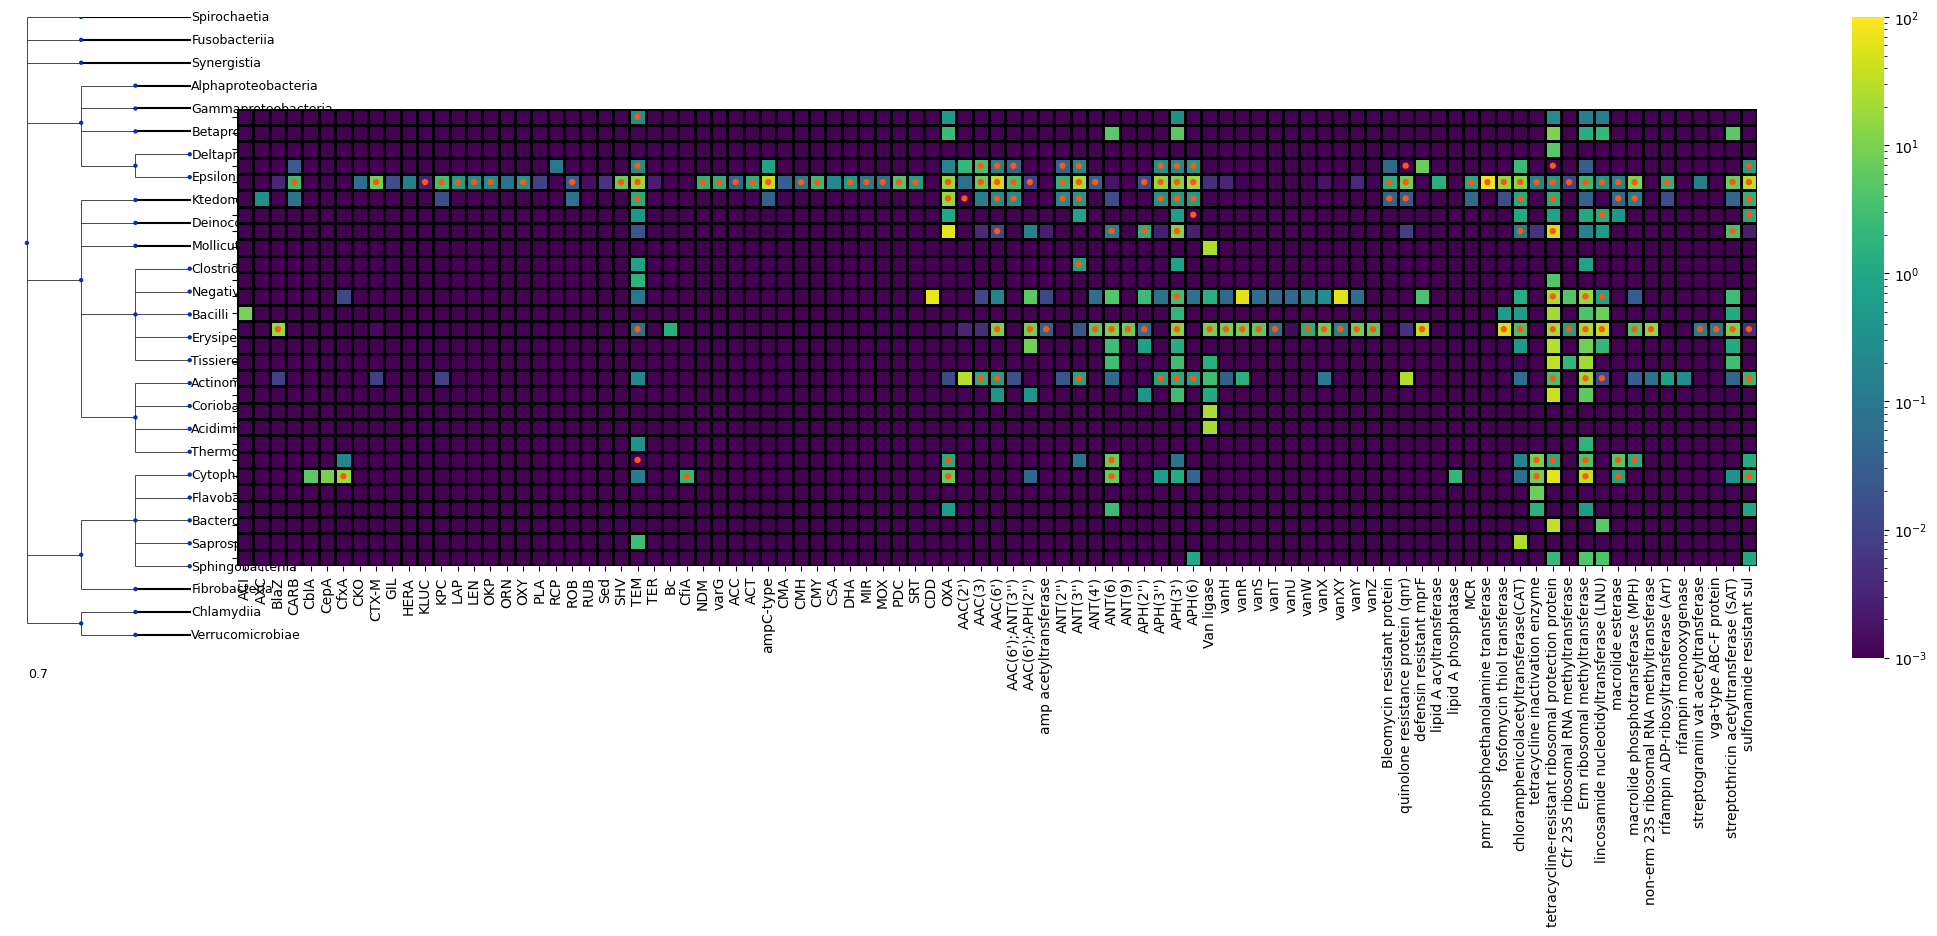

In [25]:
fig, ax = plt.subplots(1,2, figsize=(22,7), sharey='row', gridspec_kw={'width_ratios': [1,10]})
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()


#heatmap
ordered_pivot_df=ordered_pivot_df.fillna(0.0001)
sns.heatmap(ordered_pivot_df, cmap='viridis', linewidth=1, linecolor='black', ax=ax[1], norm=LogNorm(vmin=0.001, vmax=100), square=True)
coords = plot_tree(prune_tree, align_names=True, name_offset=None, max_dist=3, font_size=9, axe=ax[0])

## add plasmid markings
edge_colors=['#CC5803',"#FF5714"]
for coord in p_coord_list: 
    ax[1].add_patch(Circle(coord, radius=0.15, color=edge_colors[1]))#, 1, 1, fill=False, edgecolor=edge_colors[3], lw=2))


#plt.savefig(WRK+"rgi_analysis/figures/finalish_heatmaps/all_genes_full_analysis_reorder_"+tax+"_level_bars_heatmap.png")
#plt.savefig(WRK+"rgi_analysis/figures/finalish_heatmaps/all_genes_full_analysis_reorder_"+tax+"_level_bars_heatmap.svg")

In [26]:
len(ordered_pivot_df.index)

28

# Comparing the global prevelence VS the isolates results

### Compare the distance with the global prevelence of the genes

In [94]:
global_prev=pd.read_csv(KMA+"output_files/arg_profiles/body_site_gene_family_profiles.txt",sep='\t', index_col=0)
global_prev.head(2)

AMR Gene Family display_name     Resistance Mechanism  \
0          AAC(3)       AAC(3)  antibiotic inactivation   
1          AAC(3)       AAC(3)  antibiotic inactivation   

                     grouped_family Antibioitic Types Grouping  \
0  aminoglycoside acetyltransferase   aminoglycosides        B   
1  aminoglycoside acetyltransferase   aminoglycosides        B   

  mechansim_and_beta_lactams   scatter_groups    ARO Name  gene_count  \
0    antibiotic inactivation  aminoglycosides  AAC(3)-IId       386.0   
1    antibiotic inactivation  aminoglycosides  AAC(3)-IIe       132.0   

   percent_prevelence  
0            2.665930  
1            0.911665

In [49]:
tax_level='genus'
tax_levels=["phylum","class","order","family","genus"]
group_cols=list(hit_df.columns[0:12])
all_tax_counts=pd.DataFrame()
for i, tax_level in enumerate(tax_levels):
    tax_counting_df=hit_df[group_cols+[tax_level]].drop_duplicates()
    tax_counts=tax_counting_df.groupby(group_cols).size().reset_index(name=tax_level+'_count')
    if i == 0:
        all_tax_counts = tax_counts
    else:
        all_tax_counts=pd.merge(all_tax_counts, tax_counts, on=group_cols)
all_tax_counts

AMR Gene Family            display_name  \
0                   AAC(2')                 AAC(2')   
1                   AAC(2')                 AAC(2')   
2                   AAC(2')                 AAC(2')   
3                   AAC(2')                 AAC(2')   
4                   AAC(2')                 AAC(2')   
..                      ...                     ...   
599  vga-type ABC-F protein  vga-type ABC-F protein   
600  vga-type ABC-F protein  vga-type ABC-F protein   
601  vga-type ABC-F protein  vga-type ABC-F protein   
602  vga-type ABC-F protein  vga-type ABC-F protein   
603  vga-type ABC-F protein  vga-type ABC-F protein   

             Resistance Mechanism  \
0         antibiotic inactivation   
1         antibiotic inactivation   
2         antibiotic inactivation   
3         antibiotic inactivation   
4         antibiotic inactivation   
..                            ...   
599  antibiotic target protection   
600  antibiotic target protection   
601  antibiotic target protection   
602  antibiotic target protection   
603  antibiotic target protection   

                              antibioitc_classes  \
0                                 aminoglycoside   
1                                 aminoglycoside   
2                                 aminoglycoside   
3                                 aminoglycoside   
4                                 aminoglycoside   
..                                           ...   
599  streptogramin,streptogramin A,pleuromutilin   
600  streptogramin,streptogramin A,pleuromutilin   
601  streptogramin,streptogramin A,pleuromutilin   
602  streptogramin,streptogramin A,pleuromutilin   
603  streptogramin,streptogramin A,pleuromutilin   

                       grouped_family  \
0    aminoglycoside acetyltransferase   
1    aminoglycoside acetyltransferase   
2    aminoglycoside acetyltransferase   
3    aminoglycoside acetyltransferase   
4    aminoglycoside acetyltransferase   
..                                ...   
599                     streptogramin   
600                     streptogramin   
601                     streptogramin   
602                     streptogramin   
603                     streptogramin   

                               Antibioitic Types Grouping  \
0                                aminoglycosides       B1   
1                                aminoglycosides       B1   
2                                aminoglycosides       B1   
3                                aminoglycosides       B1   
4                                aminoglycosides       B1   
..                                           ...      ...   
599  streptogramin,streptogramin A,pleuromutilin        I   
600  streptogramin,streptogramin A,pleuromutilin        I   
601  streptogramin,streptogramin A,pleuromutilin        I   
602  streptogramin,streptogramin A,pleuromutilin        I   
603  streptogramin,streptogramin A,pleuromutilin        I   

       mechansim_and_beta_lactams              scatter_groups      aro_rep  \
0         antibiotic inactivation             aminoglycosides  ARO:3002523   
1         antibiotic inactivation             aminoglycosides  ARO:3002524   
2         antibiotic inactivation             aminoglycosides  ARO:3002525   
3         antibiotic inactivation             aminoglycosides  ARO:3002526   
4         antibiotic inactivation             aminoglycosides  ARO:3002527   
..                            ...                         ...          ...   
599  antibiotic target protection  macrolide, colistin, other  ARO:3000118   
600  antibiotic target protection  macrolide, colistin, other  ARO:3002830   
601  antibiotic target protection  macrolide, colistin, other  ARO:3002831   
602  antibiotic target protection  macrolide, colistin, other  ARO:3002833   
603  antibiotic target protection  macrolide, colistin, other  ARO:3004715   

                         ARO Name  \
0                      AAC(2')-Ia   
1                      AAC(2')-Ib   
2      

In [88]:

all_tax_prev=pd.merge(left=all_tax_counts, right=global_prev[['ARO Name','gene_count','percent_prevelence']], on='ARO Name', how='outer')
all_tax_prev

AMR Gene Family display_name     Resistance Mechanism antibioitc_classes  \
0            AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
1            AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
2            AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
3            AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
4            AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
...              ...          ...                      ...                ...   
1042             NaN          NaN                      NaN                NaN   
1043             NaN          NaN                      NaN                NaN   
1044             NaN          NaN                      NaN                NaN   
1045             NaN          NaN                      NaN                NaN   
1046             NaN          NaN                      NaN                NaN   

                        grouped_family Antibioitic Types Grouping  \
0     aminoglycoside acetyltransferase   aminoglycosides       B1   
1     aminoglycoside acetyltransferase   aminoglycosides       B1   
2     aminoglycoside acetyltransferase   aminoglycosides       B1   
3     aminoglycoside acetyltransferase   aminoglycosides       B1   
4     aminoglycoside acetyltransferase   aminoglycosides       B1   
...                                ...               ...      ...   
1042                               NaN               NaN      NaN   
1043                               NaN               NaN      NaN   
1044                               NaN               NaN      NaN   
1045                               NaN               NaN      NaN   
1046                               NaN               NaN      NaN   

     mechansim_and_beta_lactams   scatter_groups      aro_rep  \
0       antibiotic inactivation  aminoglycosides  ARO:3002523   
1       antibiotic inactivation  aminoglycosides  ARO:3002524   
2       antibiotic inactivation  aminoglycosides  ARO:3002525   
3       antibiotic inactivation  aminoglycosides  ARO:3002526   
4       antibiotic inactivation  aminoglycosides  ARO:3002527   
...                         ...              ...          ...   
1042                        NaN              NaN          NaN   
1043                        NaN              NaN          NaN   
1044                        NaN              NaN          NaN   
1045                        NaN              NaN          NaN   
1046                        NaN              NaN          NaN   

                       ARO Name                 Drug Class  phylum_count  \
0                    AAC(2')-Ia  aminoglycoside antibiotic           1.0   
1                    AAC(2')-Ib  aminoglycoside antibiotic           1.0   
2                    AAC(2')-Ic  aminoglycoside antibiotic           1.0   
3                    AAC(2')-Id  aminoglycoside antibiotic           1.0   
4                    AAC(2')-Ie  aminoglycoside antibiotic           1.0   
...                         ...                        ...           ...   
1042                 tet(O/W/O)                        NaN           NaN   
1043                tet(W/32/O)                        NaN           NaN   
1044                 tet(W/N/W)                        NaN           NaN   
1045  vanS gene in vanC cluster                        NaN           NaN   
1046  vanS gene in vanD cluster                        NaN           NaN   

      class_count  order_count  family_count  genus_count  gene_count  \
0             1.0          1.0           1.0          1.0         NaN   
1             1.0          1.0           1.0          2.0         NaN   
2             1.0          1.0           1.0          1.0         1.0   
3             1.0          1.0           1.0          2.0         NaN   
4             1.0          1.0           1.0          1.0         NaN   
...           ...          ...           ...          ...         ...  

### Does time since durg or gene discover impact global prevelence or taxonomic spread of gene families?

In [35]:
emergence_dates=pd.read_csv(KMA+"output_files/metadata/emergence_dates.txt",sep='\t')
gene_fam_counts=pd.read_csv(KMA+"output_files/figures/heatmaps/all_arg_99_clusters_per_family_bars_axis_labels.txt", sep='\t', index_col=0)

In [36]:
### count the number of taxa for each gene family
tax_levels=["phylum","class","order","family","genus"]
group_cols=list(hit_df.columns[0:8])
all_tax_counts=pd.DataFrame()
for i, tax_level in enumerate(tax_levels):
    ### only keep detections found in at least 2 genomes
    tax_counting_df=hit_df.groupby(group_cols+[tax_level]).size().reset_index(name='genome_count')
    tax_counting_df = tax_counting_df[tax_counting_df['genome_count'] >=2]   ### filter out single detections
   # tax_counting_df=hit_df[group_cols+[tax_level]].drop_duplicates()
    tax_counts=tax_counting_df.groupby(group_cols).size().reset_index(name=tax_level+'_count')
    if i == 0:
        all_tax_counts = tax_counts
    else:
        all_tax_counts=pd.merge(all_tax_counts, tax_counts, on=group_cols)
all_tax_counts.head(2)

AMR Gene Family display_name     Resistance Mechanism antibioitc_classes  \
0         AAC(2')      AAC(2')  antibiotic inactivation     aminoglycoside   
1          AAC(3)       AAC(3)  antibiotic inactivation     aminoglycoside   

                     grouped_family Antibioitic Types Grouping  \
0  aminoglycoside acetyltransferase   aminoglycosides       B1   
1  aminoglycoside acetyltransferase   aminoglycosides       B1   

  mechansim_and_beta_lactams  phylum_count  class_count  order_count  \
0    antibiotic inactivation             3            4            5   
1    antibiotic inactivation             3            7           22   

   family_count  genus_count  
0             7           13  
1            32           52

In [37]:
### get the global prevelence for each gene family
site_prev_all=pd.read_csv(KMA+"output_files/arg_profiles/body_site_gene_family_profiles.txt",sep='\t', index_col=0)
### fix the fucking vancomycin discrepancy 
van_fix={'glycopeptide resistance gene cluster;vanH':'vanH','glycopeptide resistance gene cluster;vanR':'vanR',
'glycopeptide resistance gene cluster;vanU':'vanU','glycopeptide resistance gene cluster;vanW':'vanW',
'glycopeptide resistance gene cluster;vanX':'vanX','glycopeptide resistance gene cluster;vanXY':'vanXY',
'glycopeptide resistance gene cluster;vanY':'vanY'}
new_fams=[]
for item in site_prev_all['AMR Gene Family']:
    if item in van_fix: new_fams.append(van_fix[item])
    else: new_fams.append(item)
site_prev_all['AMR Gene Family']=new_fams
site_prev=site_prev_all[site_prev_all['body_site']=='stool']
### add these genes which were not detected in the metagenomes
site_prev.loc[len(site_prev)]=['stool','VIM beta-lactamase',0,0,0,0,0,0.005]
site_prev.loc[len(site_prev)]=['stool','IMP beta-lactamase',0,0,0,0,0,0.005]
site_prev.head(2)

compiled_fam_time=pd.merge(left=site_prev, right=emergence_dates[['display_name','AMR Gene Family','gene_year','drug_year','gene_time','drug_time']], on='AMR Gene Family', how='inner')
compiled_fam_time=pd.merge(left=compiled_fam_time, right=all_tax_counts, on='display_name', how='inner')
compiled_fam_time=pd.merge(left=compiled_fam_time, right=gene_fam_counts[['display_name','metagenome_count','total_count','isolate_count']], on='display_name', how='inner')
compiled_fam_time=compiled_fam_time.sort_values('grouped_family').reset_index()
#compiled_fam_time.to_csv(WRK+"rgi_analysis/publication_tabs/gene_family_tax_counts_prev_time.txt", sep='\t')
compiled_fam_time.head(2)

index body_site   AMR Gene Family_x  body_site_count  total_body_site  \
0     15     stool  SHV beta-lactamase              907            14479   
1     16     stool  TEM beta-lactamase             2539            14479   

   total_healthy  percent_healthy  percent_unhealthy  percent_body_site  \
0          10756        74.286898          25.713102           6.264245   
1          10756        74.286898          25.713102          17.535741   

  display_name  ...  Grouping  mechansim_and_beta_lactams  phylum_count  \
0          SHV  ...         A                beta-lactams             1   
1          TEM  ...         A                beta-lactams             9   

   class_count order_count family_count genus_count metagenome_count  \
0            1           4            6          18              6.0   
1           14          34           48          68              4.0   

  total_count isolate_count  
0         7.0           2.0  
1        16.0           1.0  

[2 rows x 29 columns]

In [38]:
compiled_fam_time[compiled_fam_time['display_name']=='MCR']

index body_site                    AMR Gene Family_x  body_site_count  \
27     13     stool  MCR phosphoethanolamine transferase               99   

    total_body_site  total_healthy  percent_healthy  percent_unhealthy  \
27            14479          10756        74.286898          25.713102   

    percent_body_site display_name  ...  Grouping  \
27           0.683749          MCR  ...         E   

      mechansim_and_beta_lactams  phylum_count  class_count order_count  \
27  antibiotic target alteration             1            2           6   

   family_count genus_count metagenome_count total_count isolate_count  
27            9          21              3.0        16.0           8.0  

[1 rows x 29 columns]

In [50]:
from scipy.stats.stats import pearsonr
from scipy import stats

site_prev_pivot = pd.pivot_table(site_prev_all, index='body_site', columns='AMR Gene Family', values='percent_body_site').fillna(0).T

corr_stats=[]
for tax in tax_levels:
    pearson=pearsonr(compiled_fam_time["gene_time"], compiled_fam_time[tax+"_count"])
    spearman=stats.spearmanr(compiled_fam_time["gene_time"], compiled_fam_time[tax+"_count"])
    corr_stats.append(['time',tax, pearson[0], pearson[1], spearman[0], spearman[1]])
    
    pearson=pearsonr(compiled_fam_time["percent_body_site"], compiled_fam_time[tax+"_count"])
    spearman=stats.spearmanr(compiled_fam_time["percent_body_site"], compiled_fam_time[tax+"_count"])
    corr_stats.append(['global_prev',tax, pearson[0], pearson[1], spearman[0], spearman[1]])    

test_cases=['total_count','metagenome_count','isolate_count']
for case in test_cases:
    pearson=pearsonr(compiled_fam_time["gene_time"], compiled_fam_time[case])
    spearman=stats.spearmanr(compiled_fam_time["gene_time"], compiled_fam_time[case])
    corr_stats.append(['time','gene_'+case, pearson[0], pearson[1], spearman[0], spearman[1]])   
    
    pearson=pearsonr(compiled_fam_time["percent_body_site"], compiled_fam_time[case])
    spearman=stats.spearmanr(compiled_fam_time["percent_body_site"], compiled_fam_time[case])
    corr_stats.append(['global_prev','gene_'+case, pearson[0], pearson[1], spearman[0], spearman[1]])

body_sites=['oralcavity','skin']
for site in body_sites:
    pearson=pearsonr(site_prev_pivot["stool"], site_prev_pivot[site])
    spearman=stats.spearmanr(site_prev_pivot["stool"], site_prev_pivot[site])
    corr_stats.append(['stool', site, pearson[0], pearson[1], spearman[0], spearman[1]])  
pearson=pearsonr(site_prev_pivot["skin"], site_prev_pivot['oralcavity'])
spearman=stats.spearmanr(site_prev_pivot["skin"], site_prev_pivot['oralcavity'])
corr_stats.append(['skin', 'oralcavity', pearson[0], pearson[1], spearman[0], spearman[1]])     
    
    
pearson=pearsonr(compiled_fam_time["gene_time"], compiled_fam_time["percent_body_site"])
spearman=stats.spearmanr(compiled_fam_time["gene_time"], compiled_fam_time["percent_body_site"])

corr_stats.append(['time','global_prev', pearson[0], pearson[1], spearman[0], spearman[1]])    
corr_stats=pd.DataFrame(corr_stats, columns=["test1","test2","pearson_r","pearson_p_value",'spearman_r','spearman_p_value'])
corr_stats=corr_stats.sort_values(['test1'])
#corr_stats.to_csv(WRK+"rgi_analysis/figures/time_to_prevelence/filter2_all_correlation_stats.txt", sep='\t')
corr_stats=corr_stats.set_index(['test1','test2'])
corr_stats

pearson_r  pearson_p_value  spearman_r  \
test1       test2                                                           
global_prev genus                   0.662765     3.580204e-05    0.364137   
            phylum                  0.628905     1.156322e-04    0.467060   
            class                   0.648023     6.070025e-05    0.396578   
            order                   0.505043     3.196955e-03    0.340967   
            gene_isolate_count      0.057392     7.550420e-01    0.094133   
            family                  0.558414     8.955607e-04    0.373692   
            gene_metagenome_count   0.212570     2.427884e-01    0.446583   
            gene_total_count       -0.016989     9.264690e-01    0.073462   
skin        oralcavity              0.441510     5.942021e-08    0.707544   
stool       skin                    0.645870     1.196386e-17    0.583285   
            oralcavity              0.583816     5.669677e-14    0.573330   
time        gene_isolate_count      0.423659     1.568082e-02    0.291044   
            phylum                  0.531528     1.744784e-03    0.611623   
            gene_total_count        0.213508     2.406666e-01    0.303262   
            genus                   0.426675     1.487906e-02    0.529536   
            family                  0.608616     2.190384e-04    0.587469   
            order                   0.640536     7.853284e-05    0.575644   
            class                   0.577009     5.457978e-04    0.604473   
            gene_metagenome_count   0.186328     3.072217e-01    0.492583   
            global_prev             0.204795     2.608548e-01    0.461340   

                                   spearman_p_value  
test1       test2                                    
global_prev genus                      4.047578e-02  
            phylum                     7.038544e-03  
            class                      2.462878e-02  
            order                      5.616725e-02  
            gene_isolate_count         6.083358e-01  
            family                     3.513274e-02  
            gene_metagenome_count      1.040068e-02  
            gene_total_count           6.894725e-01  
skin        oralcavity                 2.985221e-22  
stool       skin                       6.048505e-14  
            oralcavity                 1.994312e-13  
time        gene_isolate_count         1.060733e-01  
            phylum                     1.998052e-04  
            gene_total_count           9.155478e-02  
            genus                      1.829173e-03  
            family                     4.076733e-04  
            order                      5.665622e-04  
            class                      2.482405e-04  
            gene_metagenome_count      4.182463e-03  
            global_prev                7.868118e-03

In [67]:
R2_frame

tax_level  time_v_prev  time_v_ta_count  tax_count_v_prev
0    phylum     0.041941         0.282522          0.395521
1     class     0.041941         0.332939          0.419933
2     order     0.041941         0.410286          0.255068
3    family     0.041941         0.370414          0.311826
4     genus     0.041941         0.182052          0.439258

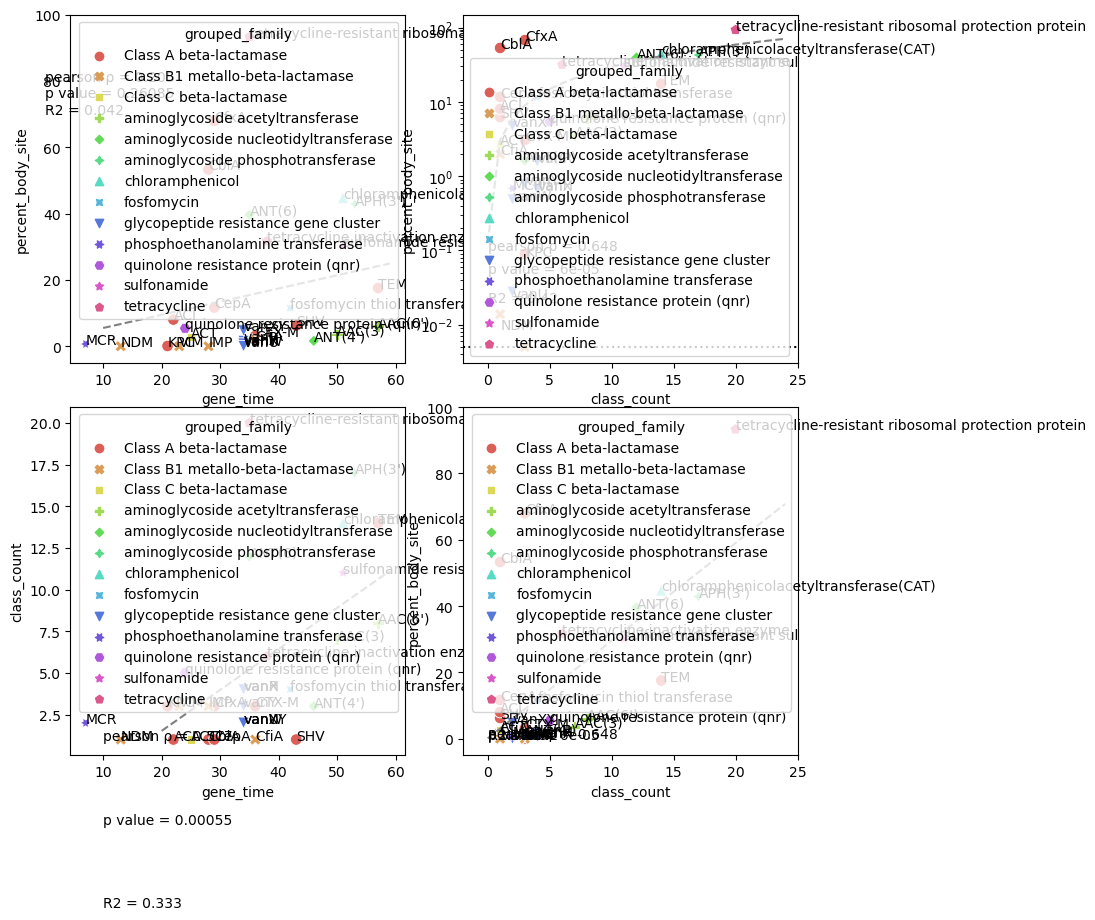

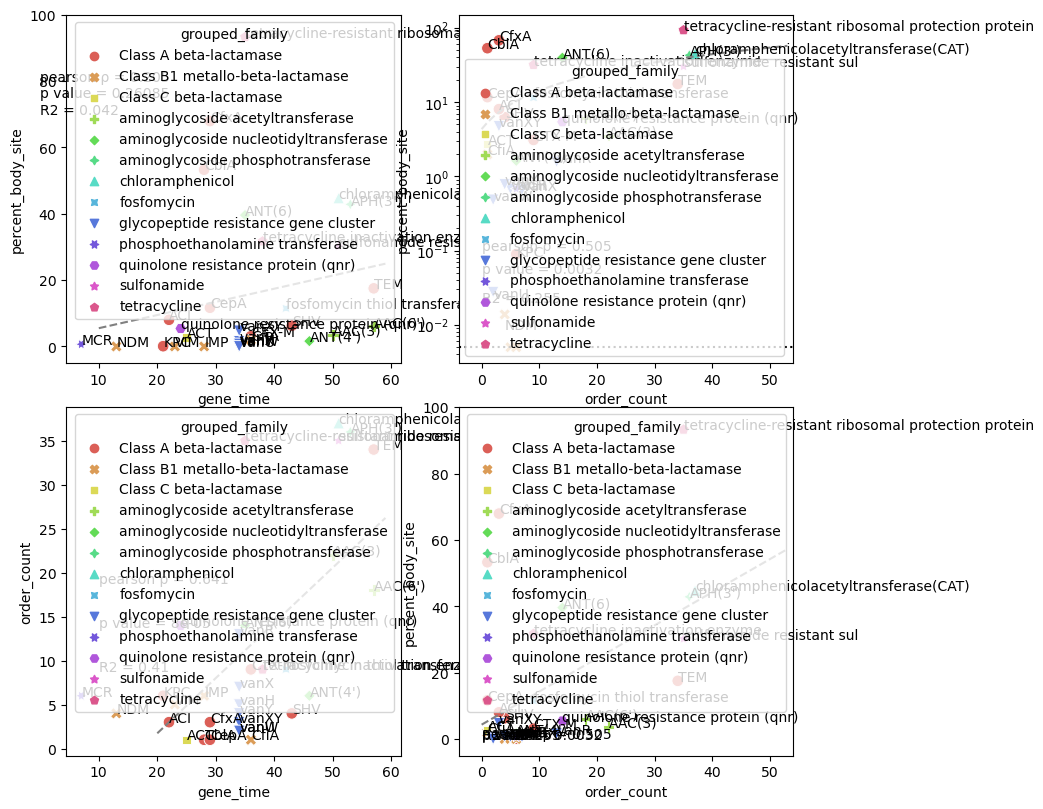

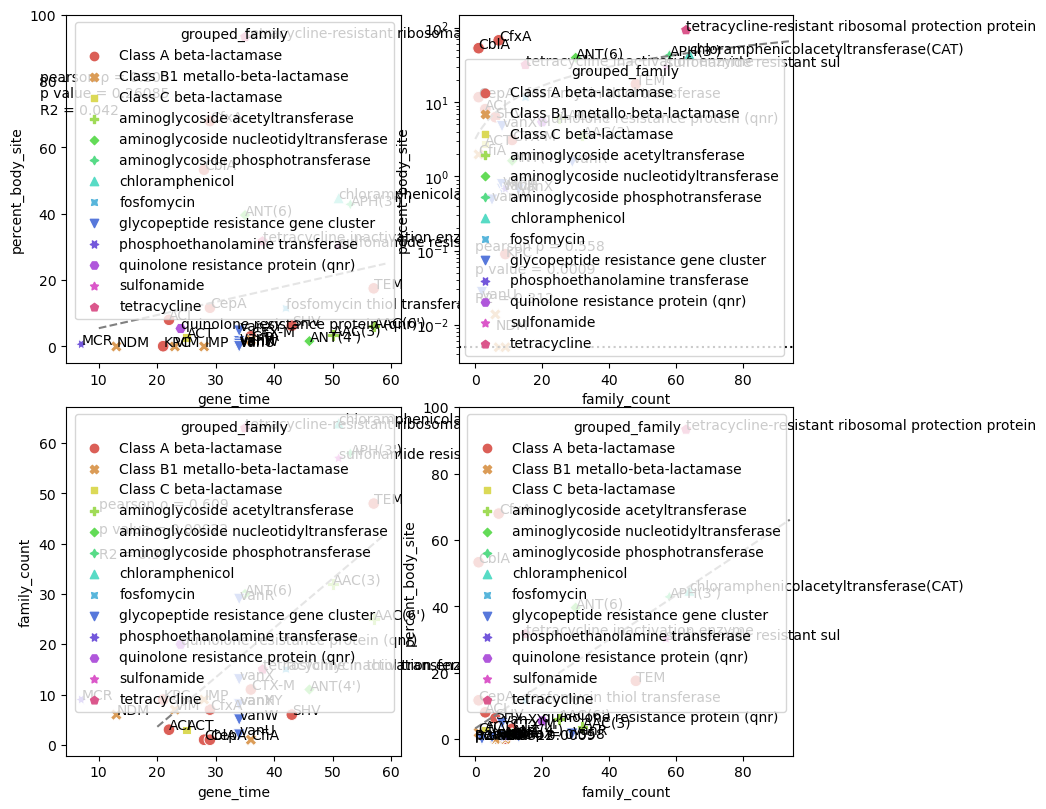

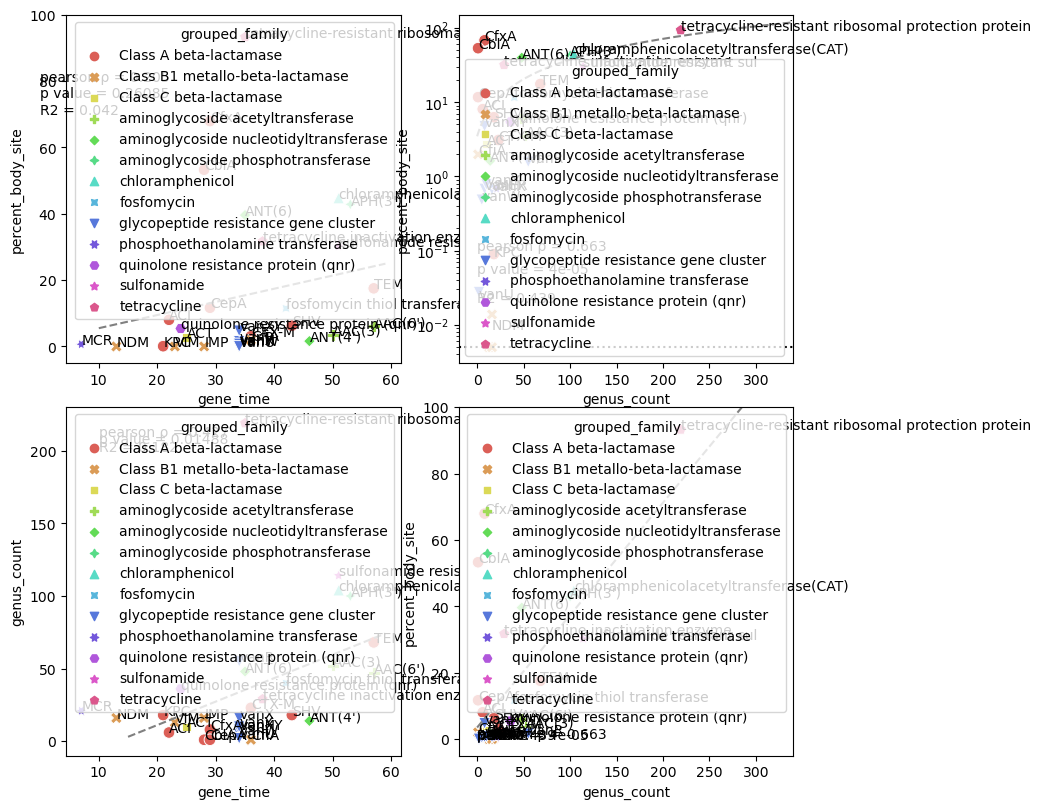

In [68]:
R2_result={}
R2_frame=[]
import matplotlib.pyplot as plt
for tax in tax_levels:
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    plt.rcParams['svg.fonttype'] = 'none'
    plt.tight_layout()
 #   tax='genus'

    # make the scatterplots
    sizer=70
        # time vs prevelence
    sns.scatterplot(data=compiled_fam_time, x='gene_time', y='percent_body_site', hue='grouped_family', ax=ax[0,0], palette='hls', style='grouped_family', s=sizer)
        # time vs taxa count
    sns.scatterplot(data=compiled_fam_time, x='gene_time', y=tax+'_count', hue='grouped_family', ax=ax[1,0], palette='hls', style='grouped_family', s=sizer)
        # prevelence vs taxa count
    sns.scatterplot(data=compiled_fam_time, y='percent_body_site', x=tax+'_count', hue='grouped_family', ax=ax[0,1], palette='hls', style='grouped_family', s=sizer)
    sns.scatterplot(data=compiled_fam_time, y='percent_body_site', x=tax+'_count', hue='grouped_family', ax=ax[1,1], palette='hls', style='grouped_family', s=sizer)
    
    # annotate the plot points
    for i, family in enumerate(compiled_fam_time["display_name"]):
        ax[0,0].annotate(family, (compiled_fam_time["gene_time"][i]+0.02, compiled_fam_time["percent_body_site"][i]-0.005), size=10 )
    for i, family in enumerate(compiled_fam_time["display_name"]):
        ax[1,0].annotate(family, (compiled_fam_time["gene_time"][i]+0.02, compiled_fam_time[tax+"_count"][i]-0.005), size=10 )
    for i, family in enumerate(compiled_fam_time["display_name"]):
        ax[0,1].annotate(family, (compiled_fam_time[tax+'_count'][i]+0.02, compiled_fam_time['percent_body_site'][i]-0.005), size=10 )
        ax[1,1].annotate(family, (compiled_fam_time[tax+'_count'][i]+0.02, compiled_fam_time['percent_body_site'][i]-0.005), size=10 )
    
    r2_test = compiled_fam_time[['gene_time','percent_body_site',tax+'_count',]]
    
    ### add the fit line to the time vs prevelence
    ax[0,0].set_ylim(-5,100)
    m, b = np.polyfit(compiled_fam_time["gene_time"],  compiled_fam_time["percent_body_site"], 1)
    x=list(range(10,60))
    y=[m * i + b for i in x]
    ax[0,0].plot(x, y, linestyle='dashed', color='grey')   
    r2_test['predict_TvP'] = m*r2_test['gene_time']+b

    ### fit the time vs tax count
    lower_dict={'phylum':20,'class':20,'order':20,'family':20,'genus':15}
    m, b = np.polyfit(compiled_fam_time["gene_time"],  compiled_fam_time[tax+'_count'], 1)
    x=list(range(lower_dict[tax],60))
    y=[m * i + b for i in x]
    ax[1,0].plot(x, y, linestyle='dashed', color='grey')  
    r2_test['predict_TvC'] = m*r2_test['gene_time']+b
    
    ### fit the tax count vs prev
    range_dict={'phylum':(-1,13),'class':(-2,25),'order':(-4,54),'family':(-5,95),'genus':(-20,340)}
    ax[0,1].set_yscale('log')
    ax[0,1].axhline(y=0.005, color='black', linestyle=':')
    ax[0,1].set_ylim(-5,150)
    ax[0,1].set_xlim(range_dict[tax])

    m, b = np.polyfit(compiled_fam_time[tax+'_count'],  compiled_fam_time['percent_body_site'], 1)
    x=list(range(0,range_dict[tax][1]))
    y=[m * i + b for i in x]
    ax[0,1].plot(x, y, linestyle='dashed', color='grey')   
    r2_test['predict_CvP'] = m*r2_test[tax+'_count']+b
    
    ax[1,1].set_ylim(-5,100)
    ax[1,1].set_xlim(range_dict[tax])
    ax[1,1].plot(x, y, linestyle='dashed', color='grey') 
    

    ### calculate R2 values

    corr_matrix = np.corrcoef(r2_test['percent_body_site'], r2_test['predict_TvP'])
    corr = corr_matrix[0,1]
    R2_result['TvP'] = corr**2
    corr_matrix = np.corrcoef(r2_test[tax+'_count'], r2_test['predict_TvC'])
    corr = corr_matrix[0,1]
    R2_result['TvC'] = corr**2
    corr_matrix = np.corrcoef(r2_test['percent_body_site'], r2_test['predict_CvP'])
    corr = corr_matrix[0,1]
    R2_result['CvP'] = corr**2
    
    prev_stat=corr_stats.loc['time','global_prev']
    ax[0,0].text(0,80, "pearson ρ = "+str(round(prev_stat['pearson_r'], 3)), horizontalalignment='left')
    ax[0,0].text(0,75, "p value = "+str(round(prev_stat['pearson_p_value'], 5)), horizontalalignment='left')
    ax[0,0].text(0,70, "R2 = "+str(round(R2_result['TvP'], 3)), horizontalalignment='left')
    
    tax_stat=corr_stats.loc['time',tax]
    the_lims=ax[1,0].get_ylim()
    ax[1,0].text(10,the_lims[1]-20, "pearson ρ = "+str(round(tax_stat['pearson_r'], 3)), horizontalalignment='left')
    ax[1,0].text(10,the_lims[1]-25, "p value = "+str(round(tax_stat['pearson_p_value'], 5)), horizontalalignment='left')
    ax[1,0].text(10,the_lims[1]-30, "R2 = "+str(round(R2_result['TvC'], 3)), horizontalalignment='left')
    
    more_stat=corr_stats.loc['global_prev',tax]
    ax[0,1].text(0,0.1, "pearson ρ = "+str(round(more_stat['pearson_r'], 3)), horizontalalignment='left')
    ax[0,1].text(0,0.05, "p value = "+str(round(more_stat['pearson_p_value'], 5)), horizontalalignment='left')
    ax[0,1].text(0,0.02, "R2 = "+str(round(R2_result['CvP'], 3)), horizontalalignment='left')
    
    ax[1,1].text(0,0.1, "pearson ρ = "+str(round(more_stat['pearson_r'], 3)), horizontalalignment='left')
    ax[1,1].text(0,0.05, "p value = "+str(round(more_stat['pearson_p_value'], 5)), horizontalalignment='left')
    ax[1,1].text(0,0.02, "R2 = "+str(round(R2_result['CvP'], 3)), horizontalalignment='left')
    
    R2_frame.append([tax, R2_result['TvP'], R2_result['TvC'], R2_result['CvP']])
    plt.savefig(WRK+"rgi_analysis/figures/time_to_prevelence/filter2_time_to_prev_"+tax+".png")
    plt.savefig(WRK+"rgi_analysis/figures/time_to_prevelence/filter2_time_to_prev_"+tax+".svg")
R2_frame = pd.DataFrame(R2_frame, columns=['tax_level','time_v_prev','time_v_ta_count','tax_count_v_prev'])
R2_frame.to_csv(WRK+"rgi_analysis/figures/time_to_prevelence/filter2_R2_stats.txt", sep='\t')

IndexError: index 2 is out of bounds for axis 0 with size 2

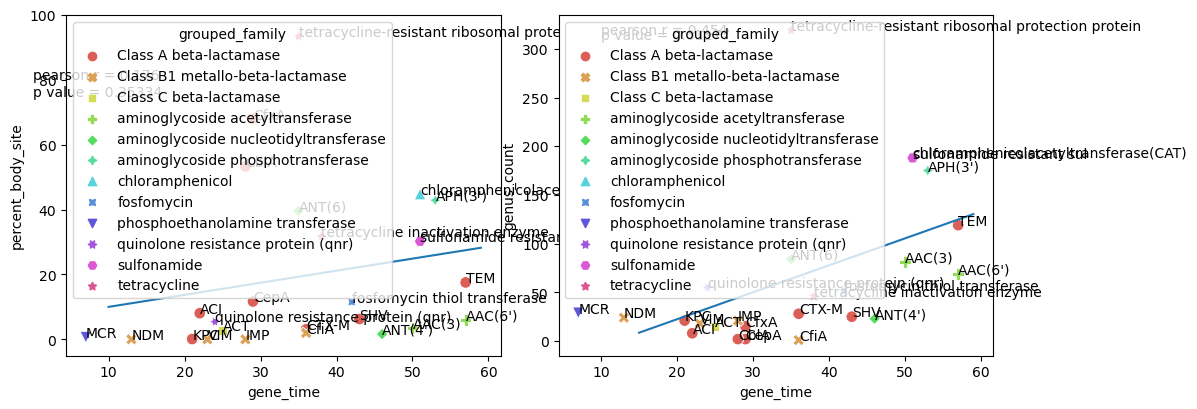

In [541]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
tax='genus'

sns.scatterplot(data=compiled_fam_time, x='gene_time', y='percent_body_site', hue='grouped_family', ax=ax[0], palette='hls', style='grouped_family', s=70)
sns.scatterplot(data=compiled_fam_time, x='gene_time', y=tax+'_count', hue='grouped_family', ax=ax[1], palette='hls', style='grouped_family', s=70)

for i, family in enumerate(compiled_fam_time["display_name"]):
    ax[0].annotate(family, (compiled_fam_time["gene_time"][i]+0.02, compiled_fam_time["percent_body_site"][i]-0.005), size=10 )
for i, family in enumerate(compiled_fam_time["display_name"]):
    ax[1].annotate(family, (compiled_fam_time["gene_time"][i]+0.02, compiled_fam_time[tax+"_count"][i]-0.005), size=10 )

ax[0].set_ylim(-5,100)
m, b = np.polyfit(compiled_fam_time["gene_time"],  compiled_fam_time["percent_body_site"], 1)
x=list(range(10,60))
y=[m * i + b for i in x]
ax[0].plot(x, y)    

lower_dict={'phylum':20,'class':20,'order':20,'family':20,'genus':15}
m, b = np.polyfit(compiled_fam_time["gene_time"],  compiled_fam_time[tax+'_count'], 1)
x=list(range(lower_dict[tax],60))
y=[m * i + b for i in x]
ax[1].plot(x, y)  

prev_stat=pearson_stats.loc['global_prev']
ax[0].text(0,80, "pearson r = "+str(round(prev_stat['pearson_r'], 3)), horizontalalignment='left')
ax[0].text(0,75, "p value = "+str(round(prev_stat['p_value'], 5)), horizontalalignment='left')

tax_stat=prev_stat=pearson_stats.loc[tax]
the_lims=ax[1].get_ylim()
ax[1].text(10,the_lims[1]-20, "pearson r = "+str(round(tax_stat['pearson_r'], 3)), horizontalalignment='left')
ax[1].text(10,the_lims[1]-25, "p value = "+str(round(tax_stat['p_value'], 5)), horizontalalignment='left')

#plt.savefig(WRK+"rgi_analysis/figures/time_to_prevelence/time_to_prev_"+tax+".png")
#plt.savefig(WRK+"rgi_analysis/figures/time_to_prevelence/time_to_prev_"+tax+".svg")

(0.23228875533769813, 0.21674982261168121)
SpearmanrResult(correlation=0.3850510305814479, pvalue=0.03562483300222159)
(0.14625666084827177, 0.4405868993784428)
SpearmanrResult(correlation=0.4332280732831002, pvalue=0.016780949878164104)
(0.43579340951413403, 0.016073867185406317)
SpearmanrResult(correlation=0.3282152243376717, pvalue=0.07660299510478182)


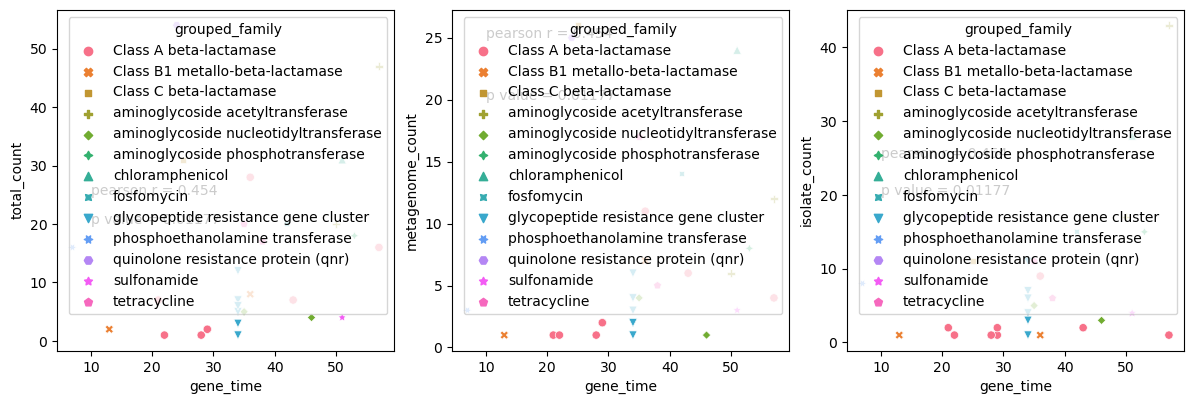

In [407]:
from scipy import stats
fig, ax = plt.subplots(1,3, figsize=(12,4))
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()

test_cases=['total_count','metagenome_count','isolate_count']
for i, case in enumerate(test_cases):
    sns.scatterplot(data=compiled_fam_time, x='gene_time', y=case, ax=ax[i], hue='grouped_family', style='grouped_family')
    pear=pearsonr(compiled_fam_time["gene_time"], compiled_fam_time[case])
    ax[i].text(10,25, "pearson r = "+str(round(prev_stat['pearson_r'], 3)), horizontalalignment='left')
    ax[i].text(10,20, "p value = "+str(round(prev_stat['p_value'], 5)), horizontalalignment='left')
    print(pear)
    spear=stats.spearmanr(compiled_fam_time["gene_time"], compiled_fam_time[case])
    print(spear)

In [464]:
total_tax_counts#[total_tax_counts['AMR Gene Family']=='IMP beta-lactamase']

class  class_count  patho_count  non_patho_count  \
0                Clostridia      17415.0      14009.0           2479.0   
1                   Bacilli     151785.0     133571.0          15718.0   
5             Actinomycetia      24140.0      11117.0           9018.0   
6                Mollicutes       1356.0        223.0           1110.0   
7       Gammaproteobacteria     279086.0     257445.0          16497.0   
...                     ...          ...          ...              ...   
204557         Tepidiformia          1.0          0.0              1.0   
227607        Tichowtungiia          1.0          0.0              1.0   
296282        Longimicrobia          3.0          0.0              3.0   
375067         Atribacteria          1.0          0.0              1.0   
548521         Thermoflexia          1.0          0.0              1.0   

        percent_patho  percent_non_patho  total_percent  
0           80.442148          14.234855      94.677003  
1           88.000132          10.355437      98.355569  
5           46.052196          37.357084      83.409279  
6           16.445428          81.858407      98.303835  
7           92.245759           5.911081      98.156841  
...               ...                ...            ...  
204557       0.000000         100.000000     100.000000  
227607       0.000000         100.000000     100.000000  
296282       0.000000         100.000000     100.000000  
375067       0.000000         100.000000     100.000000  
548521       0.000000         100.000000     100.000000  

[86 rows x 7 columns]

In [501]:
all_tax_counts[all_tax_counts["display_name"]=='VIM']

AMR Gene Family display_name     Resistance Mechanism  \
61  VIM beta-lactamase          VIM  antibiotic inactivation   

                           antibioitc_classes  \
61  carbapenem,cephalosporin,cephamycin,penam   

                     grouped_family Antibioitic Types Grouping  \
61  Class B1 metallo-beta-lactamase      beta-lactams        A   

   mechansim_and_beta_lactams  phylum_count  class_count  order_count  \
61               beta-lactams             1            3            7   

    family_count  genus_count  
61             9           18

In [498]:
all_tax_counts

AMR Gene Family  \
0                                             AAC(2')   
1                                              AAC(3)   
2                                             AAC(6')   
3                                    AAC(6');ANT(3'')   
4                                    AAC(6');APH(2'')   
..                                                ...   
90      subclass B1 Bacillus cereus Bc beta-lactamase   
91                          sulfonamide resistant sul   
92                   tetracycline inactivation enzyme   
93  tetracycline-resistant ribosomal protection pr...   
94                             vga-type ABC-F protein   

                                         display_name  \
0                                             AAC(2')   
1                                              AAC(3)   
2                                             AAC(6')   
3                                    AAC(6');ANT(3'')   
4                                    AAC(6');APH(2'')   
..                                                ...   
90                                                 Bc   
91                          sulfonamide resistant sul   
92                   tetracycline inactivation enzyme   
93  tetracycline-resistant ribosomal protection pr...   
94                             vga-type ABC-F protein   

             Resistance Mechanism  \
0         antibiotic inactivation   
1         antibiotic inactivation   
2         antibiotic inactivation   
3         antibiotic inactivation   
4         antibiotic inactivation   
..                            ...   
90        antibiotic inactivation   
91  antibiotic target replacement   
92        antibiotic inactivation   
93   antibiotic target protection   
94   antibiotic target protection   

                             antibioitc_classes  \
0                                aminoglycoside   
1                                aminoglycoside   
2                                aminoglycoside   
3                                aminoglycoside   
4                                aminoglycoside   
..                                          ...   
90                          cephalosporin,penam   
91                                  sulfonamide   
92                                 tetracycline   
93                                 tetracycline   
94  streptogramin,streptogramin A,pleuromutilin   

                      grouped_family  \
0   aminoglycoside acetyltransferase   
1   aminoglycoside acetyltransferase   
2   aminoglycoside acetyltransferase   
3   aminoglycoside acetyltransferase   
4   aminoglycoside acetyltransferase   
..                               ...   
90   Class B1 metallo-beta-lactamase   
91                       sulfonamide   
92                      tetracycline   
93                      tetracycline   
94                     streptogramin   

                              Antibioitic Types Grouping  \
0                               aminoglycosides       B1   
1                               aminoglycosides       B1   
2                               aminoglycosides       B1   
3                               aminoglycosides       B1   
4                               aminoglycosides       B1   
..                                          ...      ...   
90                                 beta-lactams        A   
91                                  sulfonamide        I   
92                                 tetracycline        H   
93                                 tetracycline        H   
94  streptogramin,streptogramin A,pleuromutilin        I   

       mechansim_and_beta_lactams  phylum_count  class_count  order_count  \
0         antibiotic inactivation             3            5            6   
1         antibiotic inactivation             3            7           26   
2         antibiotic inactivation             4            9           23   
3         antibiotic inactivation             2            4           14   
4         antibiotic in

<AxesSubplot:xlabel='variable', ylabel='value'>

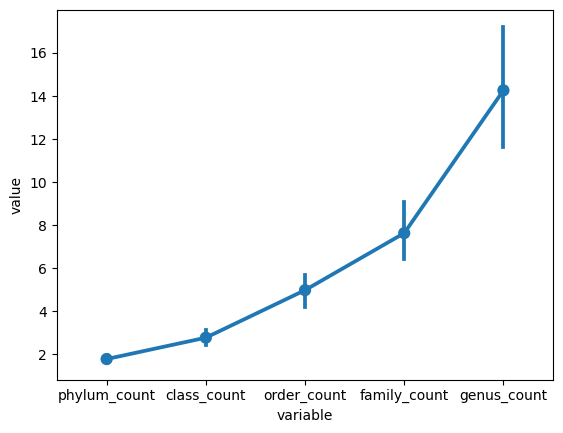

In [68]:
#pointplot
sns.pointplot(data=pd.melt(all_tax_prev, id_vars='ARO Name', value_vars=list(all_tax_prev.columns[-7:-2])), x='variable', y='value')

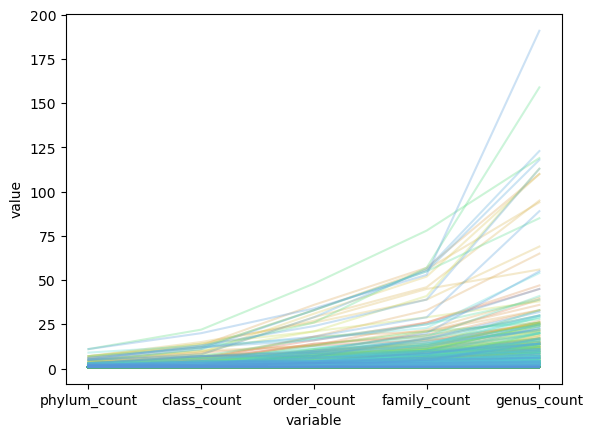

In [91]:
g=sns.lineplot(data=pd.melt(all_tax_prev, id_vars='ARO Name', value_vars=list(all_tax_prev.columns[-7:-2])), x='variable', y='value', hue='ARO Name', alpha=0.3, palette='hls')
g.get_legend().remove()
#g.set(yscale='log')

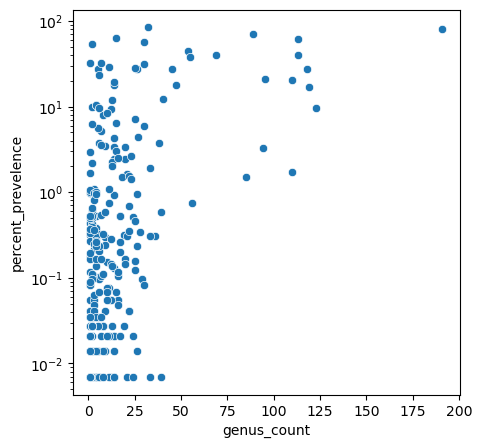

In [80]:
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams['svg.fonttype'] = 'none'

sns.scatterplot(data=all_tax_prev, x='genus_count', y='percent_prevelence')
ax.set_yscale('log')

In [84]:
all_tax_prev["scatter_groups"].drop_duplicates().sort_values().to_list()

['Class A beta-lactamase',
 'Class B/C/D beta-lactams',
 'aminoglycosides',
 'chlor, tet, quin, rif, fos, sulf',
 'macrolide, colistin, other',
 'vancomycin']

In [ ]:
gene_types=all_tax_prev["scatter_groups"].drop_duplicates().sort_values().to_list()
palette="hls"

fig, ax = plt.subplots(3, 2, figsize=(9,14), sharex='col')
plt.rcParams['svg.fonttype'] = 'none'

ax=ax.reshape(6)
for i in range(len(gene_types)):
    gene_type=gene_types[i]
    this_count=global_isolate_count.copy()
    #set zeros to small number so they're not lost
    this_count.loc[this_count["Best_Hit_ARO_percent_repvelence"] == 0, "Best_Hit_ARO_percent_repvelence"] = 0.003
    type_df=this_count[this_count["scatter_groups"]==gene_type]
    disp_names=type_df.sort_values(["scatter_groups","grouped_family","display_name"],key=lambda col: col.str.lower())["display_name"].drop_duplicates().to_list()
    coloring=sns.color_palette(palette,len(disp_names))
    c_dict=dict(zip(disp_names, coloring))
    sizes=dict(zip(disp_names, [150]*len(disp_names)))
    c_dict["zother"]='grey'
    sizes["zother"]=20
    update_names=[]
    update_groups=[]
    for index, row in global_isolate_count.iterrows():
        name=row["display_name"]
        if name in disp_names:
            update_names.append(name)
            update_groups.append(row["grouped_family"])
        else:
            update_names.append('zother')
            update_groups.append('zother')
    this_count["rename"]=update_names
    this_count["regroup"]=update_groups
    
    this_count=this_count.sort_values(["regroup","rename"], ascending=False, key=lambda col: col.str.lower())
        
    sns.scatterplot(data=this_count, x=tax+"_rep_count", y="Best_Hit_ARO_percent_repvelence",
                    hue="rename", palette=c_dict, size='rename', sizes=sizes, hue_order=disp_names+['zother'], alpha=0.8, style="rename", ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_title(gene_type)
    
 #   ax[i].set_ylim(-10,100)
  #  ax[i].set_xlim(-3,40)
    ax[i].set_yscale('log')
    ax[i].axhline(y=0.003, color='grey', linestyle=':')

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,10))
plt.rcParams['svg.fonttype'] = 'none'
ax[0][0].set_yscale('log')
ax[0][1].set_yscale('log')
#ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.scatterplot(data=dist_prev, x="max_distance", y="percent_prevelence", style="scatter_groups", ax=ax[0][0], hue="genus_count", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="genus_count", y="percent_prevelence", style="scatter_groups", ax=ax[0][1], hue="max_distance", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="max_distance", y="percent_prevelence", style="scatter_groups", ax=ax[1][0], hue="genus_count", alpha=0.8, palette="viridis", s=70)
sns.scatterplot(data=dist_prev, x="genus_count", y="percent_prevelence", style="scatter_groups", ax=ax[1][1], hue="max_distance", alpha=0.8, palette="viridis", s=70)
plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/exploritory_scatter_plots.svg")
plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/exploritory_scatter_plots.png")

<AxesSubplot:xlabel='max_distance', ylabel='genus_count'>

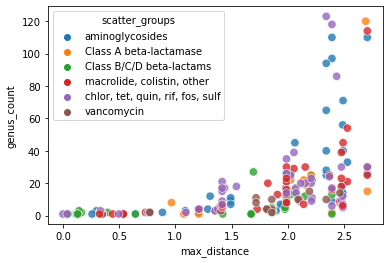

In [89]:
sns.scatterplot(data=dist_prev, x="max_distance", y="genus_count", hue="scatter_groups", alpha=0.8, s=70)

In [61]:
dist_prev[dist_prev["display_name"].isin(["CfiA","CblA","CfxA","CepA"])]

AMR Gene Family display_name     Resistance Mechanism  \
70  CblA beta-lactamase         CblA  antibiotic inactivation   
71  CepA beta-lactamase         CepA  antibiotic inactivation   
72  CfiA beta-lactamase         CfiA  antibiotic inactivation   
75  CfxA beta-lactamase         CfxA  antibiotic inactivation   
76  CfxA beta-lactamase         CfxA  antibiotic inactivation   

                     grouped_family Antibioitic Types Grouping  \
70           Class A beta-lactamase      beta-lactams        A   
71           Class A beta-lactamase      beta-lactams        A   
72  Class B1 metallo-beta-lactamase      beta-lactams        A   
75           Class A beta-lactamase      beta-lactams        A   
76           Class A beta-lactamase      beta-lactams        A   

   mechansim_and_beta_lactams            scatter_groups ARO Name  \
70               beta-lactams    Class A beta-lactamase   CblA-1   
71               beta-lactams    Class A beta-lactamase     cepA   
72               beta-lactams  Class B/C/D beta-lactams     CcrA   
75               beta-lactams    Class A beta-lactamase    CfxA2   
76               beta-lactams    Class A beta-lactamase    CfxA6   

                                           genus_list  genus_count  \
70                            Bacteroides;Phocaeicola            2   
71                            Bacteroides;Escherichia            2   
72                                        Bacteroides            1   
75  Alistipes;Bacteroides;Butyricimonas;Capnocytop...           15   
76                                         Prevotella            1   

    max_distance  gene_count  percent_prevelence  
70      2.392798      7719.0           53.311693  
71      2.392798      1690.0           11.672077  
72      2.392798       286.0            1.975275  
75      2.707654      9067.0           62.621728  
76      1.075696      4608.0           31.825402

In [53]:
dist_prev[(dist_prev["max_distance"]<1.8) & (dist_prev["percent_prevelence"]>5)].sort_values("percent_prevelence",ascending=False)

AMR Gene Family                         display_name  \
197  pmr phosphoethanolamine transferase  pmr phosphoethanolamine transferase   
76                   CfxA beta-lactamase                                 CfxA   
202  pmr phosphoethanolamine transferase  pmr phosphoethanolamine transferase   
129             ampC-type beta-lactamase                            ampC-type   
204  pmr phosphoethanolamine transferase  pmr phosphoethanolamine transferase   
203  pmr phosphoethanolamine transferase  pmr phosphoethanolamine transferase   
196  pmr phosphoethanolamine transferase  pmr phosphoethanolamine transferase   
160         fosfomycin thiol transferase         fosfomycin thiol transferase   
17                    ACI beta-lactamase                                  ACI   

             Resistance Mechanism                   grouped_family  \
197  antibiotic target alteration  phosphoethanolamine transferase   
76        antibiotic inactivation           Class A beta-lactamase   
202  antibiotic target alteration  phosphoethanolamine transferase   
129       antibiotic inactivation           Class C beta-lactamase   
204  antibiotic target alteration  phosphoethanolamine transferase   
203  antibiotic target alteration  phosphoethanolamine transferase   
196  antibiotic target alteration  phosphoethanolamine transferase   
160       antibiotic inactivation     fosfomycin thiol transferase   
17        antibiotic inactivation           Class A beta-lactamase   

    Antibioitic Types Grouping    mechansim_and_beta_lactams  \
197         colisitin        E  antibiotic target alteration   
76       beta-lactams        A                  beta-lactams   
202         colisitin        E  antibiotic target alteration   
129      beta-lactams        A                  beta-lactams   
204         colisitin        E  antibiotic target alteration   
203         colisitin        E  antibiotic target alteration   
196         colisitin        E  antibiotic target alteration   
160        fosfomycin        F       antibiotic inactivation   
17       beta-lactams        A                  beta-lactams   

                       scatter_groups                              ARO Name  \
197        macrolide, colistin, other                                  PmrF   
76             Class A beta-lactamase                                 CfxA6   
202        macrolide, colistin, other                                  eptA   
129          Class B/C/D beta-lactams  Escherichia coli ampC beta-lactamase   
204        macrolide, colistin, other                                   ugd   
203        macrolide, colistin, other                                  eptB   
196        macrolide, colistin, other                                  ArnT   
160  chlor, tet, quin, rif, fos, sulf                                 fosA5   
17             Class A beta-lactamase                                 ACI-1   

                                            genus_list  genus_count  \
197  Citrobacter;Enterobacter;Escherichia;Klebsiell...            7   
76                                          Prevotella            1   
202  Enterobacter;Escherichia;Klebsiella;Salmonella...            5   
129  Enterobacter;Escherichia;Klebsiella;Salmonella...            5   
204  Citrobacter;Enterobacter;Escherichia;Klebsiell...            6   
203     Enterobacter;Klebsiella;Providencia;Raoultella            4   
196     Enterobacter;Klebsiella;Providencia;Raoultella            4   
160  Brenneria;Chimaeribacter;Citrobacter;Cronobact...           21   
17   Acidaminococcus;Dialister;Megasphaera;Mitsuoke...            8   

     max_distance  gene_count  percent_prevelence  
197      1.415958      4610.0           31.839215  
76       1.075696      4608.0           31.825402  
202      1.415958      3923.0           27.094413  
129      1.415958      3689.0           25.478279  
204      1.415958      3378.0           23.330340  
203      1.214154      1515.0           10.463430  
196   

In [48]:
print(len(distane_measures["AMR Gene Family"].drop_duplicates()))
print(len(dist_prev["AMR Gene Family"].drop_duplicates()))

46
44


In [180]:
import warnings
warnings.filterwarnings("ignore")

tax_level=["phylum","class","order","family","genus"]

tax="genus_2"
# screen for only the taxa tht have at east a few genomes
total_tax_counts2=genomes_processed.copy().drop_duplicates(["file"])
total_tax_counts2=total_tax_counts2.groupby(tax).size().reset_index(name=tax+"_count")

genus_2  genus_2_count
0     Abditibacterium              1
1         Abiotrophia              3
2          Absicoccus              1
3            Absiella              7
4        Abyssibacter              1
...               ...            ...
3259      Zooshikella              5
3260  Zophobihabitans              1
3261     Zunongwangia              5
3262       Zymobacter              2
3263        Zymomonas             28

[3264 rows x 2 columns]

In [195]:
# select only the taxa which have a minimum number of representatives
min_genomes=10
keep_tax=total_tax_counts2[total_tax_counts2[tax+"_count"]>=min_genomes][tax].to_list()

# start counting up how many taxa each gene rep is present in
gene_rep_count=hit_df_reduced.copy().drop_duplicates(["gene_rep", tax])
gene_rep_count=gene_rep_count[gene_rep_count[tax].isin(keep_tax)]
gene_rep_count=gene_rep_count.groupby(['gene_rep',"AMR Gene Family",'grouped_family']).size().reset_index(name=tax+"_rep_count")
#gene_rep_count=pd.merge(left=gene_rep_count, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
gene_rep_count.head(2)

gene_rep  \
0  23S rRNA (adenine(2058)-N(6))-methyltransferas...   
1                                        AAC(2')-IIa   

                           AMR Gene Family  \
0  Erm 23S ribosomal RNA methyltransferase   
1                                  AAC(2')   

                        grouped_family  genus_2_rep_count  
0  23S ribosomal RNA methyltransferase                 10  
1     aminoglycoside acetyltransferase                 14

In [196]:
global_rep_abundance=pd.read_csv(HUMAAN+"publication_tabs/global_humaan/absolute_prevelence/Best_Hit_ARO_absolute_repvelence.txt",sep='\t').rename({"Best_Hit_ARO":"gene_rep"},axis=1)
global_isolate_count=pd.merge(left=gene_rep_count, right=global_rep_abundance[["gene_rep","AMR Gene Family","grouped_family","Best_Hit_ARO_percent_repvelence"]], 
                              on=["gene_rep","AMR Gene Family","grouped_family"], how='outer').fillna(0)
global_isolate_count=pd.merge(left=global_isolate_count, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping","Antibioitic Types","scatter_groups"]], on=["AMR Gene Family"], how='right')
global_isolate_count.head(2)

gene_rep                          AMR Gene Family  \
0   cfr(D)  Cfr 23S ribosomal RNA methyltransferase   
1     cfrA  Cfr 23S ribosomal RNA methyltransferase   

                        grouped_family  genus_2_rep_count  \
0  23S ribosomal RNA methyltransferase                4.0   
1  23S ribosomal RNA methyltransferase               12.0   

   Best_Hit_ARO_percent_repvelence                     display_name Grouping  \
0                         0.000000  Cfr ribosomal methyltransferase        I   
1                         0.016036  Cfr ribosomal methyltransferase        I   

                                   Antibioitic Types  \
0  streptogramins, chloramphenicols, florfenicols...   
1  streptogramins, chloramphenicols, florfenicols...   

               scatter_groups  
0  macrolide, colistin, other  
1  macrolide, colistin, other

In [235]:
this_count.loc[this_count["Best_Hit_ARO_percent_repvelence"] == 0, "Best_Hit_ARO_percent_repvelence"] = 0.0001

gene_rep                             AMR Gene Family  \
0     cfr(D)     Cfr 23S ribosomal RNA methyltransferase   
1       cfrA     Cfr 23S ribosomal RNA methyltransferase   
2       cfrC     Cfr 23S ribosomal RNA methyltransferase   
3       cipA     Cfr 23S ribosomal RNA methyltransferase   
4       clbA     Cfr 23S ribosomal RNA methyltransferase   
..       ...                                         ...   
278    vanHB  vanH; glycopeptide resistance gene cluster   
279    vanHD  vanH; glycopeptide resistance gene cluster   
280    vanHF  vanH; glycopeptide resistance gene cluster   
281    vanHM  vanH; glycopeptide resistance gene cluster   
282    vanHO  vanH; glycopeptide resistance gene cluster   

                           grouped_family  genus_2_rep_count  \
0     23S ribosomal RNA methyltransferase                4.0   
1     23S ribosomal RNA methyltransferase               12.0   
2     23S ribosomal RNA methyltransferase                5.0   
3     23S ribosomal RNA methyltransferase                1.0   
4     23S ribosomal RNA methyltransferase                3.0   
..                                    ...                ...   
278  glycopeptide resistance gene cluster                3.0   
279  glycopeptide resistance gene cluster                1.0   
280  glycopeptide resistance gene cluster                2.0   
281  glycopeptide resistance gene cluster                3.0   
282  glycopeptide resistance gene cluster                1.0   

     Best_Hit_ARO_percent_repvelence                     display_name  \
0                           0.000100  Cfr ribosomal methyltransferase   
1                           0.016036  Cfr ribosomal methyltransferase   
2                           0.048108  Cfr ribosomal methyltransferase   
3                           0.000100  Cfr ribosomal methyltransferase   
4                           0.008018  Cfr ribosomal methyltransferase   
..                               ...                              ...   
278                         1.876203                             vanH   
279                         1.371071                             vanH   
280                         0.008018                             vanH   
281                         0.000100                             vanH   
282                         0.000100                             vanH   

    Grouping                                  Antibioitic Types  \
0          I  streptogramins, chloramphenicols, florfenicols...   
1          I  streptogramins, chloramphenicols, florfenicols...   
2          I  streptogramins, chloramphenicols, florfenicols...   
3          I  streptogramins, chloramphenicols, florfenicols...   
4          I  streptogramins, chloramphenicols, florfenicols...   
..       ...                                                ...   
278        C                                         vancomycin   
279        C                                         vancomycin   
280        C                                         vancomycin   
281        C                                         vancomycin   
282        C                                         vancomycin   

                 scatter_groups  rename                               regroup  
0    macrolide, colistin, other  zother                                zother  
1    macrolide, colistin, other  zother                                zother  
2    macrolide, colistin, other  zother                                zother  
3    macrolide, colistin, other  zother                                zother  
4    macrolide, colistin, other  zother                                zother  
..                          ...     ...                                   ...  
278                  vancomycin    vanH  glycopeptide resistance gene cluster  
279                  vancomycin    vanH  glycopeptide resistance gene cluster  
280                  vancomycin    vanH  glycopeptide resistance gene cluster  
281                  vancomycin 

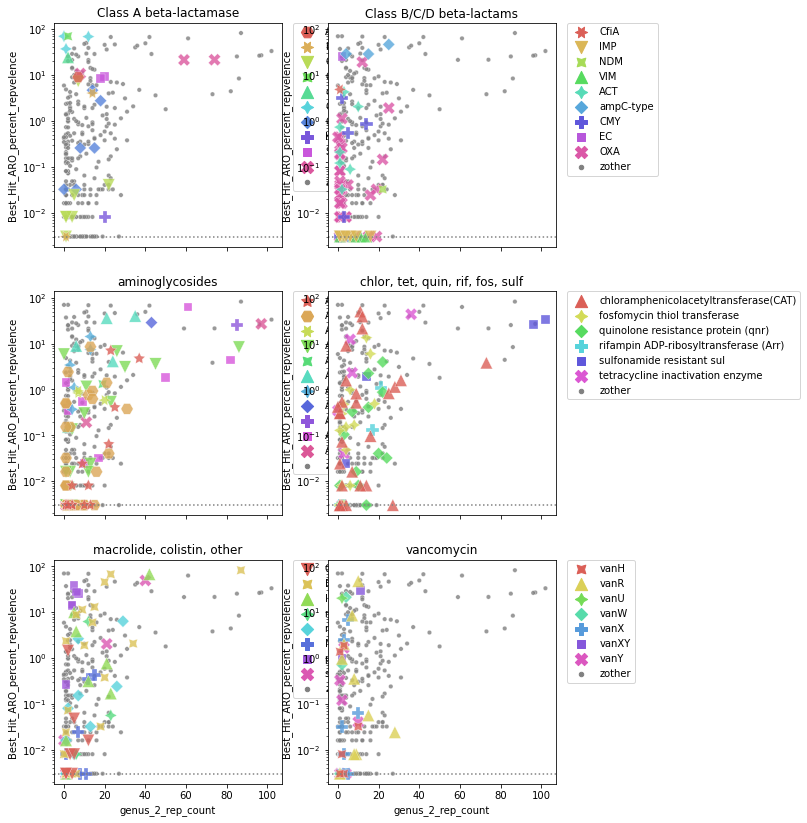

In [262]:
gene_types=global_isolate_count["scatter_groups"].drop_duplicates().sort_values().to_list()
palette="hls"

fig, ax = plt.subplots(3, 2, figsize=(9,14), sharex='col')
plt.rcParams['svg.fonttype'] = 'none'

ax=ax.reshape(6)
for i in range(len(gene_types)):
    gene_type=gene_types[i]
    this_count=global_isolate_count.copy()
    #set zeros to small number so they're not lost
    this_count.loc[this_count["Best_Hit_ARO_percent_repvelence"] == 0, "Best_Hit_ARO_percent_repvelence"] = 0.003
    type_df=this_count[this_count["scatter_groups"]==gene_type]
    disp_names=type_df.sort_values(["scatter_groups","grouped_family","display_name"],key=lambda col: col.str.lower())["display_name"].drop_duplicates().to_list()
    coloring=sns.color_palette(palette,len(disp_names))
    c_dict=dict(zip(disp_names, coloring))
    sizes=dict(zip(disp_names, [150]*len(disp_names)))
    c_dict["zother"]='grey'
    sizes["zother"]=20
    update_names=[]
    update_groups=[]
    for index, row in global_isolate_count.iterrows():
        name=row["display_name"]
        if name in disp_names:
            update_names.append(name)
            update_groups.append(row["grouped_family"])
        else:
            update_names.append('zother')
            update_groups.append('zother')
    this_count["rename"]=update_names
    this_count["regroup"]=update_groups
    
    this_count=this_count.sort_values(["regroup","rename"], ascending=False, key=lambda col: col.str.lower())
        
    sns.scatterplot(data=this_count, x=tax+"_rep_count", y="Best_Hit_ARO_percent_repvelence",
                    hue="rename", palette=c_dict, size='rename', sizes=sizes, hue_order=disp_names+['zother'], alpha=0.8, style="rename", ax=ax[i])
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_title(gene_type)
    
 #   ax[i].set_ylim(-10,100)
  #  ax[i].set_xlim(-3,40)
    ax[i].set_yscale('log')
    ax[i].axhline(y=0.003, color='grey', linestyle=':')

plt.savefig(WRK+"rgi_analysis/figures/scatter_prev/psudo_symlog"+tax+"_level_scatter.svg")

## Whihch gene families have the broadest taxonomic spread?

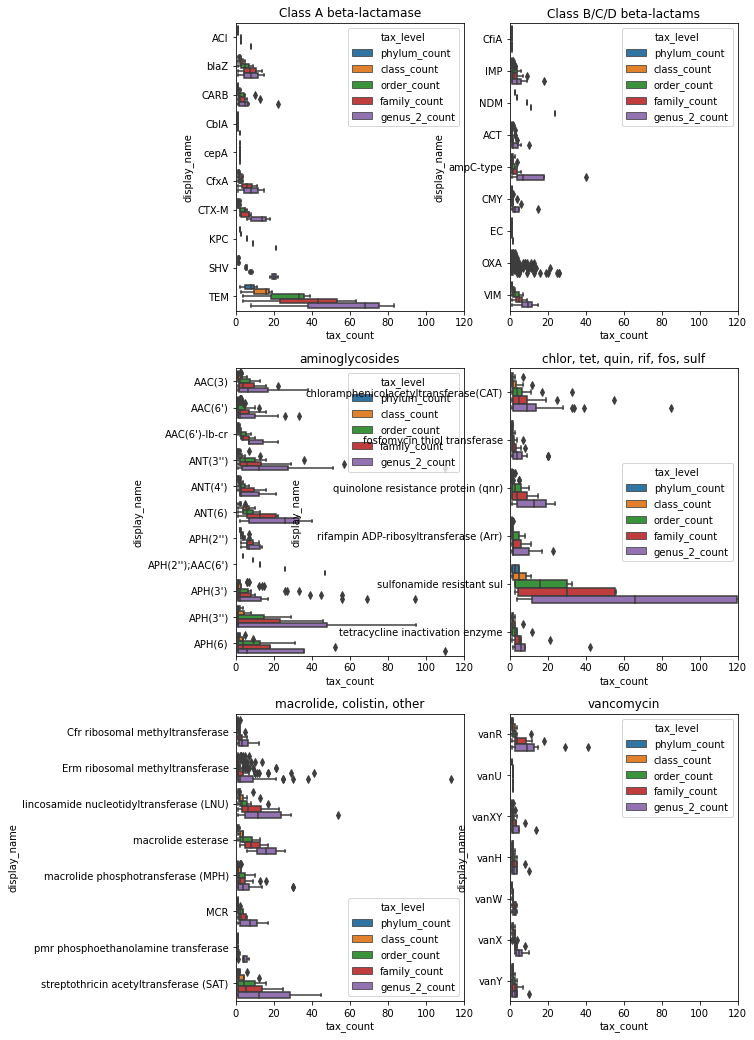

In [466]:
fig, ax = plt.subplots(3, 2, figsize=(9,18))#, sharey='row', sharex='col')
plt.rcParams['svg.fonttype'] = 'none'

ax=ax.reshape(6)
for i in range(len(gene_types)):
    gene_type=gene_types[i]
    this_count=global_isolate_count.copy()
    type_df=this_count[this_count["scatter_groups"]==gene_type]
    type_df=pd.melt(type_df, id_vars=["display_name"], value_vars=type_df.columns[3:8], var_name="tax_level", value_name="tax_count")
    sns.boxplot(data=type_df, y="display_name", x="tax_count", hue="tax_level", orient='h', ax=ax[i])
    ax[i].set_xlim((0,120))
    ax[i].set_title(gene_types[i])
plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/box_taxa_per_family.svg")

In [156]:
global_isolate_count.sort_values(["Grouping","grouped_family","display_name"]), key=lambda col: col.str.lower())

gene_rep                         AMR Gene Family  \
189                      ACI-1                      ACI beta-lactamase   
190  PC1 beta-lactamase (blaZ)                     blaZ beta-lactamase   
191             mecC-type BlaZ                     blaZ beta-lactamase   
192                     CARB-1                     CARB beta-lactamase   
193                    CARB-21                     CARB beta-lactamase   
..                         ...                                     ...   
363                      SAT-3  streptothricin acetyltransferase (SAT)   
364                       sul1               sulfonamide resistant sul   
365                       sul2               sulfonamide resistant sul   
366                       sul3               sulfonamide resistant sul   
367                       sul4               sulfonamide resistant sul   

                       grouped_family  genus_2_rep_count  \
189            Class A beta-lactamase                7.0   
190            Class A beta-lactamase               14.0   
191            Class A beta-lactamase                1.0   
192            Class A beta-lactamase               22.0   
193            Class A beta-lactamase                1.0   
..                                ...                ...   
363  streptothricin acetyltransferase                0.0   
364         sulfonamide resistant sul               96.0   
365         sulfonamide resistant sul              102.0   
366         sulfonamide resistant sul               14.0   
367         sulfonamide resistant sul                4.0   

     Best_Hit_ARO_percent_repvelence                            display_name  \
189                         8.972097                                     ACI   
190                         4.049070                                    blaZ   
191                         0.000000                                    blaZ   
192                         0.040090                                    CARB   
193                         0.008018                                    CARB   
..                               ...                                     ...   
363                         0.016036  streptothricin acetyltransferase (SAT)   
364                        26.443233               sulfonamide resistant sul   
365                        33.410840               sulfonamide resistant sul   
366                         1.908275               sulfonamide resistant sul   
367                         0.024054               sulfonamide resistant sul   

    Grouping Antibioitic Types                    scatter_groups  
189        A      beta-lactams            Class A beta-lactamase  
190        A      beta-lactams            Class A beta-lactamase  
191        A      beta-lactams            Class A beta-lactamase  
192        A      beta-lactams            Class A beta-lactamase  
193        A      beta-lactams            Class A beta-lactamase  
..       ...               ...                               ...  
363        K  streptothricins         macrolide, colistin, other  
364        L       sulfonamide  chlor, tet, quin, rif, fos, sulf  
365        L       sulfonamide  chlor, tet, quin, rif, fos, sulf  
366        L       sulfonamide  chlor, tet, quin, rif, fos, sulf  
367        L       sulfonamide  chlor, tet, quin, rif, fos, sulf  

[468 rows x 9 columns]

In [162]:
fig, ax = plt.subplots(figsize=(7,10))
plt.rcParams['svg.fonttype'] = 'none'
sns.boxplot(data=global_isolate_count.sort_values(["Grouping","grouped_family","display_name"], key=lambda col: col.str.lower()), y="display_name", x="genus_2_rep_count", orient='h')
plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/box_genus_per_family.svg")

### Is there a relation between number of genomes and number of genes found?

In [484]:
tax_level=["phylum","class","order","family","genus_2"]
tax_dict=dict(zip(tax_level,range(5)))
tax="order"

total_tax_counts3=genomes_processed.copy().drop_duplicates(["file"])
total_tax_counts3=total_tax_counts3.groupby([tax]).size().reset_index(name="genome_count")
total_tax_counts3=pd.merge(left=total_tax_counts3, right=genomes_processed[[tax,'pathogen']].sort_values('pathogen', ascending=False).drop_duplicates(tax), on=tax, how='left')

# start counting up how many taxa each gene rep is present in

### here I remove other gene fams that we didn't look at
tax_rep_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
tax_rep_count=tax_rep_count.copy().drop_duplicates([tax,"gene_rep"])
#tax_rep_count=tax_rep_count[tax_rep_count[tax].isin(keep_tax)]
tax_rep_count=tax_rep_count.groupby(tax_level[:tax_dict[tax]+1]).size().reset_index(name=tax+"_gene_count")
tax_rep_count=pd.merge(left=tax_rep_count, right=total_tax_counts3, on=tax, how='left').fillna(0)
tax_rep_count.head(2)

patho_rename=[]
for patho in tax_rep_count["pathogen"]:
    if patho: patho_rename.append('pathogenic')
    else: patho_rename.append('non-pathogenic')
tax_rep_count["pathogen"]=patho_rename

tax_rep_count.head(2)

phylum          class               order  order_gene_count  \
0  Actinobacteria  Actinomycetia     Actinomycetales                10   
1  Actinobacteria  Actinomycetia  Actinopolysporales                 1   

   genome_count        pathogen  
0           396      pathogenic  
1            13  non-pathogenic

In [485]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams['svg.fonttype'] = 'none'
#tax_rep_count=tax_rep_count[tax_rep_count["phylum"]!="Proteobacteria"]
ax = sns.scatterplot(data=tax_rep_count.sort_values("phylum", ascending=False), x="genome_count", y=tax+"_gene_count", hue="phylum", size='pathogen', style='phylum', 
                     size_order=["pathogenic","non-pathogenic"], sizes=(50,200), alpha=0.8)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xscale('log')
ax.set_ylabel("Total ARGs Detected")
ax.set_xlabel("Total Genomes Processed")

#plt.savefig(WRK+"rgi_analysis/figures/misc_metrics/scatter_linear_select_fam_args_vs_total_genomes.svg")

Text(0.5, 0, 'Total Genomes Processed')

## Rarefaction of genomes maybe???

In [89]:
#### Generates a rarefation for the givin taxa at the givin taxonomic level
def sample_tax(count_df, level, taxa, min_sample=10, scale=0.1, reps=5, max_genomes=1000000):
    import statistics
    from random import sample
    
    rare_out=[]
    this_tax=count_df[count_df[level]==taxa]
    all_files=this_tax["file"].drop_duplicates().to_list()

    stop=len(all_files)
    if stop > max_genomes: stop=max_genomes
    i=5
    while i < stop:  
        these_samples=[]
        for x in range(reps):
            file_sample=sample(all_files, int(i))
            sample_df=this_tax[this_tax["file"].isin(file_sample)]
            count=len(sample_df["gene_rep"].drop_duplicates())
            these_samples.append(count)
        mean_sample=statistics.mean(these_samples)
        rare_out.append([taxa, i, mean_sample])      
        i=i+i*scale
    
    return rare_out

In [ ]:
selected_gene_fams=pd.read_csv(WRK+"rgi_analysis/publication_tabs/selected_gene_fams_V1.txt",sep='\t')
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')

In [113]:
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=rare_count.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(rare_count, level, taxa, min_sample=5, scale=0.05, reps=15, max_genomes=1000000)
    output_rare=output_rare+rare_out

  0%|          | 0/14 [00:00<?, ?it/s]

14


100%|██████████| 14/14 [14:05<00:00, 60.39s/it]


In [114]:
tax_df_rare=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"])
#tax_df_rare.to_csv(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.txt", sep='\t')

In [134]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=tax_df_rare, x="genome_count", y="ARG_count", hue='order', ax=ax[0])
sns.lineplot(data=tax_df_rare, x="genome_count", y="ARG_count", hue='order', ax=ax[1])
ax[1].set_xlim((-200,4000))

ax[0].set_xscale('log')
ax[0].set_yscale('log')

#plt.savefig(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.png")

In [265]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=class_rare, x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=class_rare, x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

#ax[0].set_xscale('log')
#ax[0].set_yscale('log')

plt.savefig(WRK+"rgi_analysis/figures/rarefaction/"+level+"_15rep_rarefaction_tab.svg")

## Use all genes and not just the selected

In [126]:
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=hit_df_reduced.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(hit_df_reduced, level, taxa, min_sample=50, scale=0.05, reps=2, max_genomes=1000000)
    output_rare=output_rare+rare_out

  0%|          | 0/9 [00:00<?, ?it/s]

9


100%|██████████| 9/9 [02:30<00:00, 16.67s/it]


(-200.0, 4000.0)

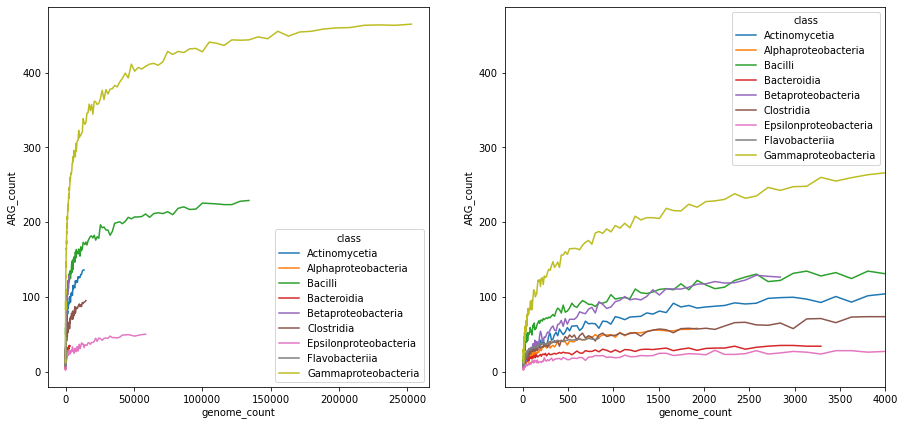

In [127]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

In [118]:
selected_gene_fams=pd.read_csv(WRK+"rgi_analysis/publication_tabs/selected_gene_fams_V1.txt",sep='\t')
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')
rare_count=rare_count.drop_duplicates(["file","AMR Gene Family"])
import tqdm as tqdm
level="class"
minimum_genomes=500
tax_counts=rare_count.drop_duplicates(["file",level]).groupby(level).size().reset_index(name="count")
tax_list=tax_counts[tax_counts["count"]>=minimum_genomes][level].to_list()
print(len(tax_list))

8


In [120]:
output_rare=[]
for taxa in tqdm.tqdm(tax_list):
    rare_out=sample_tax(rare_count, level, taxa, min_sample=50, scale=0.05, reps=1, max_genomes=1000000)
    output_rare=output_rare+rare_out

100%|██████████| 8/8 [00:50<00:00,  6.35s/it]


In [121]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
plt.rcParams['svg.fonttype'] = 'none'

sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[0])
sns.lineplot(data=pd.DataFrame(output_rare, columns=[level,"genome_count","ARG_count"]), x="genome_count", y="ARG_count", hue=level, ax=ax[1])
ax[1].set_xlim((-200,4000))

(-200.0, 4000.0)

In [122]:
rare_count=pd.merge(left=hit_df_reduced, right=selected_gene_fams[["AMR Gene Family","display_name","Grouping"]], on=["AMR Gene Family"], how='right')